# Predicting Flight Cancellations

## Overview

Over 99% of all scheduled domestic flights take off, and the rest are very expensive. Of over 10 million flights scheduled flights each year, hundreds of thousands never leave the tarmac. At an average of $5770 in losses per cancellation this adds up to nearly a billion dollars of opportunity. While a significant chunk of those losses is unavoidable, it stands to reason that if an airline could confidently predict a cancellation far enough in advance, they could start taking measures to reduce those losses by doing things such as rebooking stranded passengers and rescheduling flight crews.

The aim of this project is to build a predictive model that can tell an airline that an upcoming flight will be cancelled at least a day before it actually happens.

The code in this notebook goes through all of the necessary steps to: 
* Download the required datasets
* Build a SQL database containing the data
* Process the data into features usable by machine learning models
* Join the data into a pandas DataFrame  design matrix
* Scrub and prepare the data for modeling
* Build, train, and tune models using cross validation
* Select a final model and predict it's effectiveness with a holdout dataset.

# Data Sources

## Flight Records

My data set is primarily derived from the "[Marketing Carrier On-Time Performance](https://www.transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time#)" report released by the Bureau of Transportation Statistics. This database contains information on nearly every flight conducted by a significant U.S. carrier dating back to January 1987.

As that amount of data is pretty unwieldy for a prototype, for the purposes of this project I've narrowed the scope to only making predictions on flights departing from the start of 2007 to the end of 2018.

## Weather Records

To supplement the flight data, the model also makes use of historical weather data for the same time duration. This weather data is acquired via the Dark Sky API, and gives hourly records of precipitation, temperature, wind, visibility, and more. 

## Future Work

There are a number of additional features that this model would likely benefit from that have not yet been incorporated. Likely future resources include aircraft specific features that can be acquired by cross referencing with [this database](https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download/) from the FAA.

In [7]:
## %%writefile ../src/data/make_dataset.py

# Imports
from io import BytesIO
import os
import urllib.request
from zipfile import ZipFile
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import sqlalchemy
from sqlalchemy import create_engine
import datetime
from pytz import timezone
from datetime import timedelta
import pytz
import json
import requests
import numpy as np
import pandas as pd

# Helper functions


def get_lookup_tables():
    # Reporting carrier lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS'
    # Reporting airline lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRLINE_ID'
    # Airport ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT_ID'
    # City Market ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_CITY_MARKET_ID'
    # Airport lookup table (SEA -> Seattle-Tacoma International)
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT'
    
    lookups = [
        'L_UNIQUE_CARRIERS',
        'L_AIRLINE_ID',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID',
        'L_AIRPORT',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID'
    ]
    lookup_base = 'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup='
    for table in lookups:
        download_lookup(lookup_base + table)
    pass


def get_weather_forecast_url(lat, lon, time):
    """
    """
    # Weather forecast API
    with open('../src/darksky.api', 'r') as f:
        api = f.read()
    key = api
    
    # URL attributes
    base = 'https://api.darksky.net/forecast/'
    tail = '?exclude=currently,flags'
    
    # Construct
    url = f'{base}{key}/{lat},{lon},{time}{tail}'
    
    return url


def get_weather_data(start_date, end_date, overwrite='ask'):
    """
    """
    if overwrite == 'ask':
        overwrite = input(f'Get weather data? y/n: ')
    if overwrite.lower() != 'y':
        return
    
    table = 'weather'
    params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }
    
    connection_string = f"postgresql:///{params['dbname']}"
    engine = create_engine(connection_string)
    
    # SeaTac Coordinates
    lat = 47.4502
    lon = -122.3088
    
    date = end_date
    print(f'Getting weather data for {date} to {end_date}...')
    while date > start_date:
        e_date = date.strftime("%s")
        url = get_weather_forecast_url(lat, lon, e_date)
#         try:
        r = requests.get(url)
        if r.ok:
            day_weather = r.json()
            data = pd.DataFrame(day_weather['hourly']['data'])
            data['datetime'] = pd.to_datetime(data['time'], unit='s')
            data['date'] = data['datetime'].dt.date
            data['hour'] = data['datetime'].dt.hour - 8
            try:
                data.to_sql(table, engine, if_exists='append', index=False)
            except:
                print(f'Failed to append {date} to table.')
        else:
            print(f'No data for {date}. Error {r.status_code}')
        date -= timedelta(days=1)
        if date.strftime('%m-%d') == '01-01':
            year = date.strftime('%Y')
            print(f'Collected data for {year}')
    print(f'Wrote weather data from {start_date} to {end_date} to table {table}')
    return


def file_exists(path, filename):
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    return file_exists

    
def download_dataset(url, path, filename, overwrite='ask'):
    """
    Downloads zip file from specified url and extracts csv file to raw data 
    directory
    Input: 
        url: string of url from which to retrieve data
        path: string of directory path to store file in
        filename: string of desired filename
        overwrite: parameter for whether or not to overwrite existing files, if
            found. If 'y', any existing file with filename in path will be
            overwritten. If 'n', function will do nothing. If 'ask', function
            will prompt user to decide whether or not to replace file.
    Output: dataset stored in raw data directory
    """
    filepath = path + filename
    if file_exists(path, filename):
        if overwrite == 'ask':
            overwrite = input(f'{filename} already exists. Update? y/n: ')
        if overwrite.lower() != 'y':
            return
                              
    print(f'Beginning download of {filename}...')
    try:
        zip_f = urllib.request.urlopen(url)
        with ZipFile(BytesIO(zip_f.read())) as my_zip_file:
            for f in my_zip_file.namelist():
                if '.csv' in f:
                    with open(filepath, 'wb') as output:
                        for line in my_zip_file.open(f).readlines():
                            output.write(line)
        print(f'Successfully wrote {filename} to {path}')
                              
    except urllib.request.HTTPError:
        print(f'Failed to download {filename}')
        return


def get_flight_data_url(year, month):
    '''
    Generate URL to download pre-zipped csv of flight data for a given month as
    provided by the Bureau of Transportation Statistics
    Input: Year in format YYYY (int), Month in format of (M)M, i.e. 3, or 11
    Output: download URL as a string
    '''
    base_url = 'http://transtats.bts.gov/PREZIP/'
    tail = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_'
    slug = f'{year}_{month}.zip'
    return base_url + tail + slug
    

def get_flight_data(start, end, path, overwrite='ask'):
    '''
    Downloads a variety of flight data tables from:
    https://www.transtats.bts.gov/Fields.asp
    '''
    # Download all BTS datasets
    for year in range(start, end):
        for month in range(1,13):
            filename = f'flight_data_{year}-{month}.csv'
            url = get_flight_data_url(year, month)
            download_dataset(url, path, filename, overwrite)
    pass


def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
#     get_flight_data(2003, 2020, path, overwrite='n')
    
    pacific = timezone('US/Pacific')
    start = datetime.datetime(2003, 1, 1, 0, 0, 0, tzinfo=pacific)
    end = datetime.datetime(2019, 4, 30, 0, 0, 0, tzinfo=pacific)
    get_weather_data(start, end, overwrite='ask')
    # download_dataset_1(url)
    # download_dataset_2(url)
    # save_dataset_1('data/raw', filename)
    # save_dataset_2('data/raw', filename)
    pass

In [8]:
run()

Get weather data? y/n: y
Getting weather data for 2019-04-30 00:00:00-07:53 to 2019-04-30 00:00:00-07:53...
Failed to append 2019-03-08 00:00:00-07:53 to table.
Failed to append 2019-03-07 00:00:00-07:53 to table.
Failed to append 2019-02-11 00:00:00-07:53 to table.
Failed to append 2019-02-10 00:00:00-07:53 to table.
Failed to append 2019-02-09 00:00:00-07:53 to table.
Failed to append 2019-02-08 00:00:00-07:53 to table.
Failed to append 2019-02-06 00:00:00-07:53 to table.
Failed to append 2019-02-05 00:00:00-07:53 to table.
Failed to append 2019-02-04 00:00:00-07:53 to table.
Failed to append 2019-02-03 00:00:00-07:53 to table.
Collected data for 2019
Failed to append 2018-02-25 00:00:00-07:53 to table.
Failed to append 2018-02-24 00:00:00-07:53 to table.
Failed to append 2018-02-23 00:00:00-07:53 to table.
Failed to append 2018-02-22 00:00:00-07:53 to table.
Failed to append 2018-02-18 00:00:00-07:53 to table.
Collected data for 2018
Failed to append 2017-12-26 00:00:00-07:53 to tab

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

## Features
The following is a list of features I'd like to have in the design matrix:


| Feature                               | Description                                                  | Type        | Purpose |
| ------------------------------------- | ------------------------------------------------------------ | ----------- | ------- |
| Airline ID                            | ID number to identify unique airline                         | Categorical | Key     |
| AL_C_rate_day                         | Flight cancellation rate by this airline at this airport over past 24 hours | Continuous  | Feature |
| AL_C_rate_7                           | Flight cancellation rate by this airline on this weekday 1 week ago | Continuous  | Feature |
| AL_C_avg_rate_week                    | Flight cancellation rate by this airline at this airport over past 7 days | Continuous  | Feature |
| AL_C_rate_28                          | Flight cancellation rate by this airline on this weekday 4 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_month                   | Flight cancellation rate by this airline at this airport over past 30 days | Continuous  | Feature |
| AL_C_rate_364                         | Flight cancellation rate by this airline on this weekday 52 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_year                    | Flight cancellation rate by this airline at this airport over past 365 days | Continuous  | Feature |
| Tail number                           | Unique airplane identifier ID                                | Categorical | Key     |
| AP_C_rate_day                         | Flight cancellation rate by this airplane over past 24 hours | Continuous  | Feature |
| AP_C_rate_7                           | Flight cancellation rate by this airplane on this weekday 1 week ago | Continuous  | Feature |
| AP_C_avg_rate_week                    | Flight cancellation rate by this airplane at this airport over past 7 days | Continuous  | Feature |
| AP_C_rate_28                          | Flight cancellation rate by this airplane on this weekday 4 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_month                   | Flight cancellation rate by this airplane at this airport over past 30 days | Continuous  | Feature |
| AP_C_rate_364                         | Flight cancellation rate by this airplane on this weekday 52 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_year                    | Flight cancellation rate by this airplane at this airport over past 365 days | Continuous  | Feature |
| Origin Airport ID                     | Unique airport identifier ID for flight origin               | Categorical | Key     |
| orig_C_rate_day                       | Flight cancellation rate for flights departing from origin airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Origin City Market                    | ID for area that may be served by several airlines           | Categorical | Key     |
| OCM_C_rate_day                        | Flight cancellation rate for flights departing from origin city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest Airport ID                       | Unique airport identifier ID for destination                 | Categorical | Key     |
| dest_C_rate_day                       | Flight cancellation rate for flights heading to destination airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest City Market                      | ID for area that may be served by several airlines           | Categorical | Key     |
| DCM_C_rate_day                        | Flight cancellation rate for flights heading to destination city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Departure time                        | Scheduled departure time                                     | ?           |         |
| Airtime                               | Planned time in air, in minutes                              | Continuous  |         |
| Distance                              | Planned route distance                                       | Continuous  |         |
| On-time incoming arrival percentage   | Percent of flights that arrive at departure airport on-time  | Continuous  |         |
| On-time outgoing departure percentage | Percent of flights that depart from departure airport on-time | Continuous  |         |
| Historical cancellation percentages   | All time average                                             | Continuous  |         |
|                                       | 1 day ago                                                    | Continuous  |         |
|                                       | 7 days ago                                                   | Continuous  |         |
|                                       | 30 days ago                                                  | Continuous  |         |
|                                       | 364 days ago                                                 | Continuous  |         |
|                                       | For this airline                                             | Continuous  |         |
|                                       | From this airport                                            | Continuous  |         |
|                                       | To that airport                                              | Continuous  |         |
|                                       | On this airplane (tail number)                               | Continuous  |         |
|                                       | On this airplane model                                       | Continuous  |         |
| Historical delays (goes back to 2003) | The average number of minutes that a similar incoming flight has been delayed (in minutes) over the avove time periods, for the reasons: carrier delay, weather delay, national air system delay, security delay, and late aircraft delay |             |         |
|                                       |                                                              |             |         |
| Weather Forecast                      | What the weather forecast was ~24 hours ago, in degrees      | Continuous  |         |
| Other airline/craft statistics        |                                                              |             |         |
| Cancelled                             | Boolean for whether or not flight is cancelled, 1=Yes        | Boolean     |         |
| Cancellation Code                     | Reason for cancellation (carrier, weather, national air system, security) | Categorical |         |



## Process

In [27]:
# %%writefile ../src/features/build_features.py

# Imports
import csv
from os import listdir
import subprocess
import sys
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
import pandas as pd


# Helper functions
def export_design_matrix(df):
    """
    Pickles design matrix and stores in processed directory to be trained on
    Input: clean design matrix df containing only features and target
    Outpu: pickled design matrix in data directory
    """
    display(df.head(), df.tail())
    df.to_pickle('../data/processed/data.pkl')
    pass


def get_day(cols, engine):
    select = ', '.join([f'"{col}"' for col in cols])
    q = f"""
    SELECT  
        LPAD((hour + 8) || '00-', 5, '0') || LPAD((hour + 8) || '59', 4, '0') AS deptimeblk,
        date + 1 AS next_day,
        {select}
    FROM weather 
    WHERE hour BETWEEN -2 AND 16
    ;"""
    day = pd.read_sql(q, engine)
    return day

    
def get_morning(engine):
    cols = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
           'ozone', 'precipIntensity', 'precipProbability',
           'pressure', 'temperature', 'uvIndex', 'visibility',
           'windBearing', 'windGust', 'windSpeed']
    calls = ' '.join([f'AVG("{col}") AS "{col}",' for col in cols])
    q = f"""
    SELECT 
        {calls}
        date + 1 AS next_day,
        '0001-0559' AS deptimeblk
    FROM weather
    WHERE hour BETWEEN -8 AND -3
    GROUP BY date
    ORDER BY date DESC;
    """
    morning = pd.read_sql(q, engine)
    return morning


def add_forecast(weather):
    """
    
    """
    data = weather.copy()
    data.to_pickle('../data/weather_test.pkl')
#     data['date'] = pd.to_datetime(weather['next_day']) - pd.Timedelta('1 day')
    data['date'] = data['next_day'] - pd.Timedelta('1 day')
    data = data.set_index(['date', 'deptimeblk'])
#     display(data.columns, data.head())
    data = data.drop('next_day', axis=1)

    # Define noise matrix
    mu, sigma = 1, 0.025 
    noise = np.random.normal(mu, sigma, data.shape)
    
    forecast = data * noise
    forecast.columns = [f'forecast_{col}' for col in forecast.columns]
    forecast.reset_index
    
#     weather['date'] = pd.to_datetime(weather['next_day'])
    weather['date'] = weather['next_day']
    weather = weather.merge(
        forecast, how='left', on=['date', 'deptimeblk']
    ).drop('next_day', axis=1)
    
    return weather

def get_weather(engine):
    morning = get_morning(engine)
    
    day_cols = morning.columns.drop(['next_day', 'deptimeblk'])
    day = get_day(day_cols, engine)

    weather = pd.concat((morning, day), keys='next_day')

    drop_cols = ['ozone']#'summary', 'precipType', 'icon']
    weather = weather.drop(columns=drop_cols)
    return weather.sort_values(by=['next_day', 'deptimeblk'])


def rolling_average_CR(engine, days, by=''):
    col = ''
    name = ''
    if by:
        col = f'{by},'
        name = f'_by_{by}'
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) + 1 as date,
        {col}
        cancelled
    FROM flights f
    WHERE
        origin='SEA'
    ORDER BY flightdate
    ;"""

    df = pd.read_sql(q, engine)
    
    if by:
        aggs = df.groupby(['date', by])['cancelled'].agg(['count', 'sum'])
    else:
        aggs = df.groupby('date')['cancelled'].agg(['count', 'sum'])
    
    rolls = aggs.rolling(days).sum()
    rolls[f'{days}_day_CR_avg{name}'] = rolls['sum'] / rolls['count']
    
    return rolls.iloc[:, -1].reset_index()


def get_group_CR(engine, by=''):
    """
    """
    col = ''
    group = ''
    part = ''
    if by:
        col = f'{by},'
        group = f'{by}, '
        part = f'PARTITION BY {by} '
        by = f'{by}_'
        
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) AS date,
        {col}
        LAG(AVG(cancelled), 1) OVER(
            {part}ORDER BY flightdate) AS {by}CR_1d_ago,
        LAG(AVG(cancelled), 7) OVER(
            {part}ORDER BY flightdate) AS {by}CR_1w_ago,
        LAG(AVG(cancelled), 28) OVER(
            {part}ORDER BY flightdate) AS {by}CR_4w_ago,
        LAG(AVG(cancelled), 364) OVER(
            {part}ORDER BY flightdate) AS {by}CR_52w_ago
    FROM flights
    WHERE 
        origin = 'SEA'
    GROUP BY {group}flightdate
    ORDER BY flightdate
    ;"""
    df = pd.read_sql(q, engine)
    return df


def build_design_matrix(engine):
    """
    """
    print('Building design matrix...')
    dm = """
    SELECT
        CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
            AS flight,
        CAST(flightdate AS DATE) AS date,
        cancelled,
        crselapsedtime AS est_time,
        distance,
        reporting_airline,
        tail_number,
        dest,
        destcitymarketid,
        deptimeblk,
        arrtimeblk
    FROM flights
    WHERE flightdate between '2007-01-01' AND '2018-12-31' AND
        origin = 'SEA'
    ORDER BY date
    ;"""
    df = pd.read_sql(dm, engine, index_col='flight')
    return df


def build_features(engine):
    """
    """
    df = build_design_matrix(engine)
    
    # Columns to aggregate by
    cols = ['reporting_airline', 'dest', 'destcitymarketid', 
            'deptimeblk', 'arrtimeblk', 'tail_number']
    
    # Get lag cancellation rates
    print('Getting lag cancellation rates')
    overwrite = 'y'
    if overwrite == 'ask':
        overwrite = input(f'Recalculate lag cancellation rate data?')
    if overwrite.lower() == 'y':
        lag = get_group_CR(engine)
        df = df.merge(lag, how='left', on='date')

        for col in cols:
            try:
                lag = get_group_CR(engine, col)
                df = df.merge(lag, how='left', on=['date', col])
            except:
                print(f'Failed to generate lag_CRs for {col}')
        df.to_pickle('../data/processed/df_w_lag_CRs.pkl')
    else:
        df = pd.read_pickle('../data/processed/df_w_lag_CRs.pkl')
        
    # Get rolling average cancellation rates
    print('Getting rolling average cancellation rates')
    cols.remove('tail_number')
    overwrite = 'y'
    if overwrite == 'ask':
        overwrite = input(f'Recalculate rolling average cancellation rate data?')
    if overwrite.lower() == 'y':
        for day in [7, 30, 365]:
            roll = rolling_average_CR(engine, day)
            df = df.merge(roll, how='left', on='date')
            for col in cols:
                try:
                    roll = rolling_average_CR(engine, day, col)
                    df = df.merge(roll, how='left', on=['date', col])
                except:
                    print(f'Failed to generate rolling_average_CRs for {col}')
        df.to_pickle('../data/processed/df_w_CRs.pkl')
    else:
        df = pd.read_pickle('../data/processed/df_w_CRs.pkl')

    # Get weather data
    print('Getting weather data')
    overwrite = 'y'
    if overwrite == 'ask':
        overwrite = input(f'Recalculate weather rate data?')
    if overwrite.lower() == 'y':
        weather = get_weather(engine)
    #     weather = df.rename(columns={'next_day': 'date'})
        weather['next_day'] = pd.to_datetime(weather['next_day'])
    #     weather = weather.drop('next_day', axis=1)
        weather = add_forecast(weather)

        # Merge weather data
        df['date'] = pd.to_datetime(df['date'])
        df = df.merge(weather, how='left', on=['date', 'deptimeblk'])
    #     df = df.merge(weather, how='left', 
    #                   left_on=['date', 'deptimeblk'],
    #                   right_on=['next_day', 'deptimeblk']
    #                  )
        df.to_pickle('../data/processed/df_w_weather.pkl')
    else:
        df = pd.read_pickle('../data/processed/df_w_weather.pkl')
    
    # Make dummies for departure time blocks
    df = pd.concat((df, pd.get_dummies(df['deptimeblk'], drop_first=True)), 
                   axis=1)
    df = df.set_index(pd.DatetimeIndex(df['date']))

    drop_cols = cols + ['date', 'tail_number_cr_52w_ago', 'tail_number']#, 'next_day'
    df = df.drop(drop_cols, axis=1)
    df = df.dropna(thresh=(df.shape[1] - 4))
    df = df.dropna()
    return df

def run_query(query, params, engine):
    '''
    Opens a connection to database to run a query, q
    Input: 
        query (str), a SQL command that requests output
        params (dict), parameters for connecting to psql, including user, host,
            and port
    Output: a pandas dataframe containing the query output
    '''
    return pd.read_sql(query, engine)

    
def show_tables(params):
    # Returns a list of all tables and views in our database
    q = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    return run_query(q, params)


def run_command(command, params):
    '''
    Opens a connection to database to run a command with no output
    Input: 
        command (str), a SQL query that commits an action
        params (dict), parameters for connecting to psql, including user, host,
            and port
    '''
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        cur.execute(command)
        pass
    
    
def check_table_exists(table, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
#     print(f'Found tables: {items}')
    exists = table in items
    return exists


def make_table(path, file, engine, table):
    df = pd.read_csv(path + file)

    drop_cols = [
        'DOT_ID_Reporting_Airline',
        'IATA_CODE_Reporting_Airline', 
        'OriginAirportSeqID', 
        'OriginStateFips',
        'OriginWac',
        'DestAirportSeqID', 
        'DestStateFips',
        'DestWac',
        'TaxiOut',
        'WheelsOff', 
        'WheelsOn', 
        'TaxiIn'
    ]

    short_df = df[df.columns[:61]].drop(drop_cols, axis=1)

    shorter_df = short_df[
        short_df['Origin'].str.contains('SEA') |
        short_df['Dest'].str.contains('SEA')
    ]

    index = (shorter_df['FlightDate'].astype(str) 
             + '_' + shorter_df['Flight_Number_Reporting_Airline'].astype(str))

    shorter_df.set_index(
        keys=index,
        inplace=True
    )

    shorter_df.columns = [col.lower() for col in shorter_df.columns]
    
    # Define types
    types = {
        'year': sqlalchemy.types.INTEGER(),
        'quarter': sqlalchemy.types.INTEGER(),
        'month': sqlalchemy.types.INTEGER(),
        'dayofmonth': sqlalchemy.types.INTEGER(),
        'dayofweek': sqlalchemy.types.INTEGER(),
        'flightdate': sqlalchemy.DateTime(),
        'reporting_airline': sqlalchemy.types.VARCHAR(),
        'tail_number': sqlalchemy.types.VARCHAR(),
        'flight_number_reporting_airline': sqlalchemy.types.VARCHAR(),
        'originairportid': sqlalchemy.types.VARCHAR(),
        'origincitymarketid': sqlalchemy.types.VARCHAR(),
        'origin': sqlalchemy.types.VARCHAR(),
        'origincityname': sqlalchemy.types.VARCHAR(),
        'originstate': sqlalchemy.types.VARCHAR(),
        'originstatename': sqlalchemy.types.VARCHAR(),
        'destairportid': sqlalchemy.types.VARCHAR(),
        'destcitymarketid': sqlalchemy.types.VARCHAR(),
        'dest': sqlalchemy.types.VARCHAR(),
        'destcityname': sqlalchemy.types.VARCHAR(),
        'deststate': sqlalchemy.types.VARCHAR(),
        'deststatename': sqlalchemy.types.VARCHAR(),
        'crsdeptime': sqlalchemy.types.INTEGER(),
        'deptime': sqlalchemy.types.INTEGER(),
        'depdelay': sqlalchemy.types.INTEGER(),
        'depdelayminutes': sqlalchemy.types.INTEGER(),
        'depdel15': sqlalchemy.types.BOOLEAN(),
        'departuredelaygroups': sqlalchemy.types.INTEGER(),
        'deptimeblk': sqlalchemy.types.VARCHAR(),
        'crsarrtime': sqlalchemy.types.INTEGER(),
        'arrtime': sqlalchemy.types.INTEGER(),
        'arrdelay': sqlalchemy.types.INTEGER(),
        'arrdelayminutes': sqlalchemy.types.INTEGER(),
        'arrdel15': sqlalchemy.types.BOOLEAN(),
        'arrivaldelaygroups': sqlalchemy.types.INTEGER(),
        'arrtimeblk': sqlalchemy.types.VARCHAR(),
        'cancelled': sqlalchemy.types.INTEGER(),
        'cancellationcode': sqlalchemy.types.VARCHAR(),
        'diverted': sqlalchemy.types.VARCHAR(),
        'crselapsedtime': sqlalchemy.types.VARCHAR(),
        'actualelapsedtime': sqlalchemy.types.INTEGER(),
        'airtime': sqlalchemy.types.INTEGER(),
        'flights': sqlalchemy.types.INTEGER(),
        'distance': sqlalchemy.types.INTEGER(),
        'distancegroup': sqlalchemy.types.INTEGER(),
        'carrierdelay': sqlalchemy.types.VARCHAR(),
        'weatherdelay': sqlalchemy.types.VARCHAR(),
        'nasdelay': sqlalchemy.types.VARCHAR(),
        'securitydelay': sqlalchemy.types.VARCHAR(),
        'lateaircraftdelay': sqlalchemy.types.VARCHAR(),
    }
                  
    # Add to SQL table
    shorter_df.to_sql(
        table, engine, if_exists='append', dtype=types, index=False)
    print(f'Added {file} to table {table}')
                  
    int_path = '../data/interim/'
    shorter_df.to_csv(f'{int_path}reduced_{file}')
    print(f'Wrote {file} to {int_path}')
    pass

                  
def check_db_exists(db, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = 'SELECT datname FROM pg_database;'
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
#     print(f'Found items: {items}')
    exists = db in items
    return exists
                  
                  
def create_db(dbname, params):
    '''
    Connects to psql as default user and creates new database if it doesn't
    already exist
    Input:
        dbname (string), name of new database
        params (dict), parameters for connecting to psql, including user, host,
        and port
    Output: database created in psql
    '''
    
    temp_params = params.copy()
    temp_params['dbname'] = 'postgres'
    with connect(**temp_params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        exists = check_db_exists(dbname, cur)
        if not exists:
            cur.execute(f'CREATE DATABASE {dbname}')
            print(f'Created database {dbname}')
    pass
        

def build_raw_database(params, engine, overwrite='ask'):
    '''
    Constructs database from raw data CSVs previously downloaded
    '''
    path = '../data/raw/'

    create_db(dbname=params['dbname'], params=params)
    table_name = 'flights'
    
    # Check whether table exists and prompt about dropping
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        print(f"Connecting to database {params['dbname']}")
        cur = conn.cursor()
        exists = check_table_exists(table_name, cur)
        if exists:
            if overwrite == 'ask':
                overwrite = input(f'{table_name} already exists. Update? y/n:')
            if overwrite.lower() != 'y':
                return
            run_command('DROP TABLE flights;', params)

    # Collect list of csvs
    files = [f for f in listdir(path) if '.csv' in f]
    files = sorted(files)
    
    # Shrink files and load all into SQL table
    for file in files:
        make_table(path, file, engine, table_name)
    pass
        
def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }
    
    connection_string = f"postgresql:///{params['dbname']}"
    engine = create_engine(connection_string)
              
    build_raw_database(params, engine, overwrite='n')
    data = build_features(engine)
    export_design_matrix(data)
    return data

## Load Data

In [148]:
%time data = run()
display(data.shape, data.head(), data.info())

Connecting to database raw_flight_data
Building design matrix...
Getting lag cancellation rates
Getting rolling average cancellation rates
Getting weather data


cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2007-01-01          0    320.0      2553   0.007407   0.010676   0.010601   
2007-01-01          0    161.0      1050   0.007407   0.010676   0.010601   
2007-01-01          0    219.0      1449   0.007407   0.010676   0.010601   
2007-01-01          0    193.0      1399   0.007407   0.010676   0.010601   
2007-01-01          0    173.0      1216   0.007407   0.010676   0.010601   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.125                     0.000000  ...   
2007-01-01                        0.000                     0.023438  ...   

            1400-1459  1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  \
date                                                                           
2007-01-01          0          0          0          0          0          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          1          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          0          0   

            2000-2059  2100-2159  2200-2259  2300-2359  
date                                                    
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  

[5 rows x 92 columns]

cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2018-12-31          0    158.0       954   0.002688        0.0        0.0   
2018-12-31          0    278.0      2182   0.002688        0.0        0.0   
2018-12-31          0    274.0      2182   0.002688        0.0        0.0   
2018-12-31          0    145.0       867   0.002688        0.0        0.0   
2018-12-31          0    145.0       867   0.002688        0.0        0.0   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.005917   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   

            1400-1459  1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  \
date                                                                           
2018-12-31          0          1          0          0          0          0   
2018-12-31          0          0          0          0          0          0   
2018-12-31          0          0          0          0          0          0   
2018-12-31          0          1          0          0          0          0   
2018-12-31          0          1          0          0          0          0   

            2000-2059  2100-2159  2200-2259  2300-2359  
date                                                    
2018-12-31          0          0          0          0  
2018-12-31          0          0          0          0  
2018-12-31          0          0          1          0  
2018-12-31          0          0          0          0  
2018-12-31          0          0          0          0  

[5 rows x 92 columns]

CPU times: user 3min 29s, sys: 26.4 s, total: 3min 55s
Wall time: 3min 31s
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1202639 entries, 2007-01-01 to 2018-12-31
Data columns (total 92 columns):
cancelled                              1202639 non-null int64
est_time                               1202639 non-null object
distance                               1202639 non-null int64
cr_1d_ago                              1202639 non-null float64
cr_1w_ago                              1202639 non-null float64
cr_4w_ago                              1202639 non-null float64
cr_52w_ago                             1202639 non-null float64
reporting_airline_cr_1d_ago            1202639 non-null float64
reporting_airline_cr_1w_ago            1202639 non-null float64
reporting_airline_cr_4w_ago            1202639 non-null float64
reporting_airline_cr_52w_ago           1202639 non-null float64
dest_cr_1d_ago                         1202639 non-null float64
dest_cr_1w_ago                    

(1202639, 92)

cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2007-01-01          0    320.0      2553   0.007407   0.010676   0.010601   
2007-01-01          0    161.0      1050   0.007407   0.010676   0.010601   
2007-01-01          0    219.0      1449   0.007407   0.010676   0.010601   
2007-01-01          0    193.0      1399   0.007407   0.010676   0.010601   
2007-01-01          0    173.0      1216   0.007407   0.010676   0.010601   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.125                     0.000000  ...   
2007-01-01                        0.000                     0.023438  ...   

            1400-1459  1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  \
date                                                                           
2007-01-01          0          0          0          0          0          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          1          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          0          0   

            2000-2059  2100-2159  2200-2259  2300-2359  
date                                                    
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  

[5 rows x 92 columns]

None

In [28]:
params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
}

connection_string = f"postgresql:///{params['dbname']}"
engine = create_engine(connection_string)

In [30]:
dm = """
    SELECT
        CAST(flightdate AS DATE) AS date,
        SUM(cancelled)
    FROM flights
    GROUP BY flightdate.year
    WHERE flightdate between '2007-01-01' AND '2018-12-31' AND
        origin = 'SEA'
    ORDER BY date
    ;"""
    df = pd.read_sql(dm, engine, index_col='flight')

IndentationError: unexpected indent (<ipython-input-30-f280bafa2a27>, line 11)

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [35]:
## %%writefile ../src/visualization/visualize.py

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# helper functions go here
def plot_features(df, target, sample_size=2000):
    features = df.drop(target, axis=1)
    num = features.shape[1]
    n = 5
    for i in range(num//n):
        data = features.iloc[:, i:i+n]
        data[target] = df[target]
        sample = (data.sample(2000, random_state=44)) 
        sns.pairplot(
            sample,
            hue='cancelled', 
            plot_kws=dict(alpha=.3, edgecolor='none'))


def load_features(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data


def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    target = 'cancelled'
    data = load_features('../data/processed/data.pkl')
    plot_features(data, target)
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    return data


CPU times: user 48.1 s, sys: 817 ms, total: 48.9 s
Wall time: 48.5 s


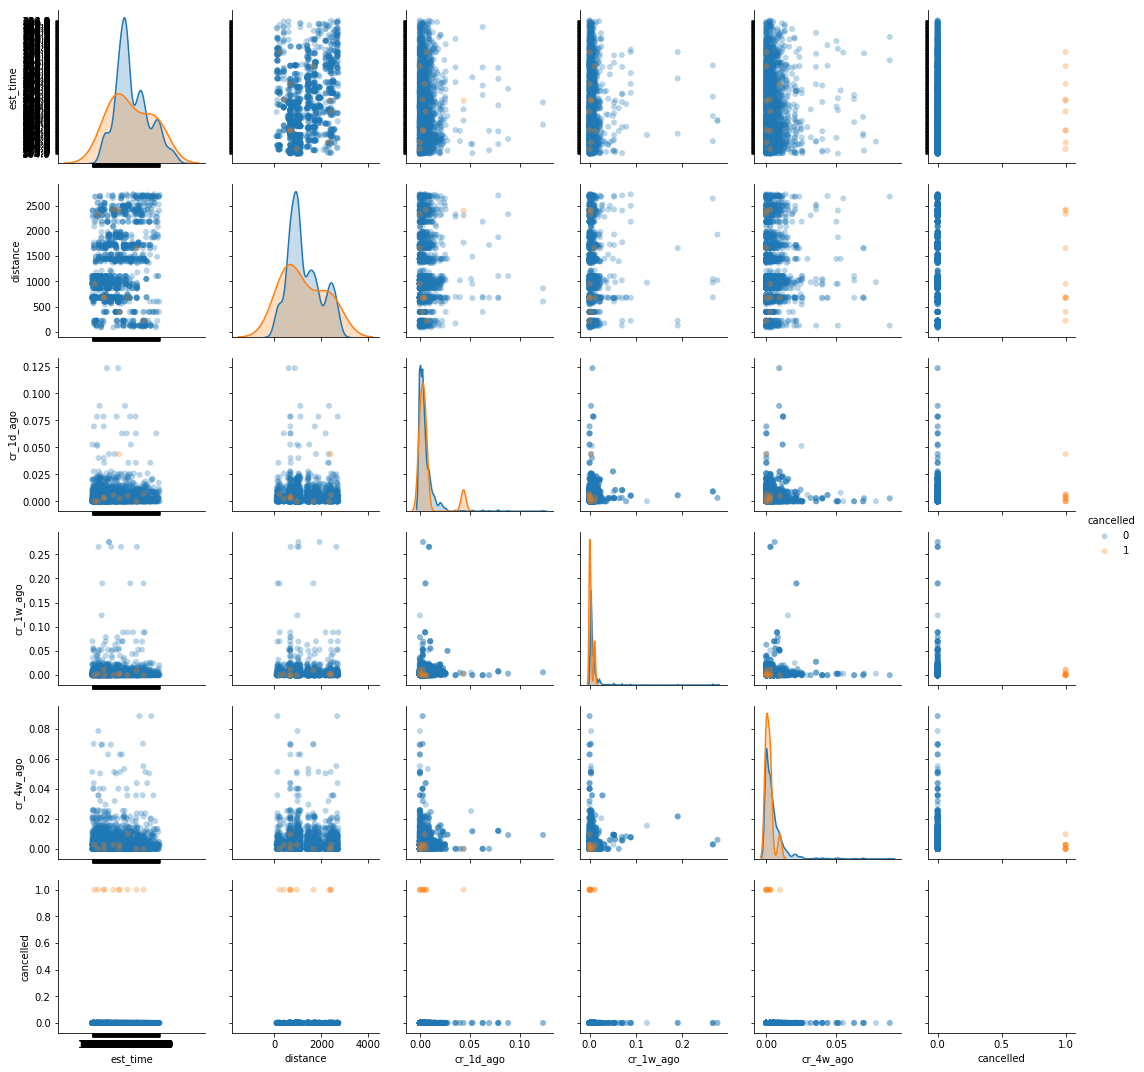

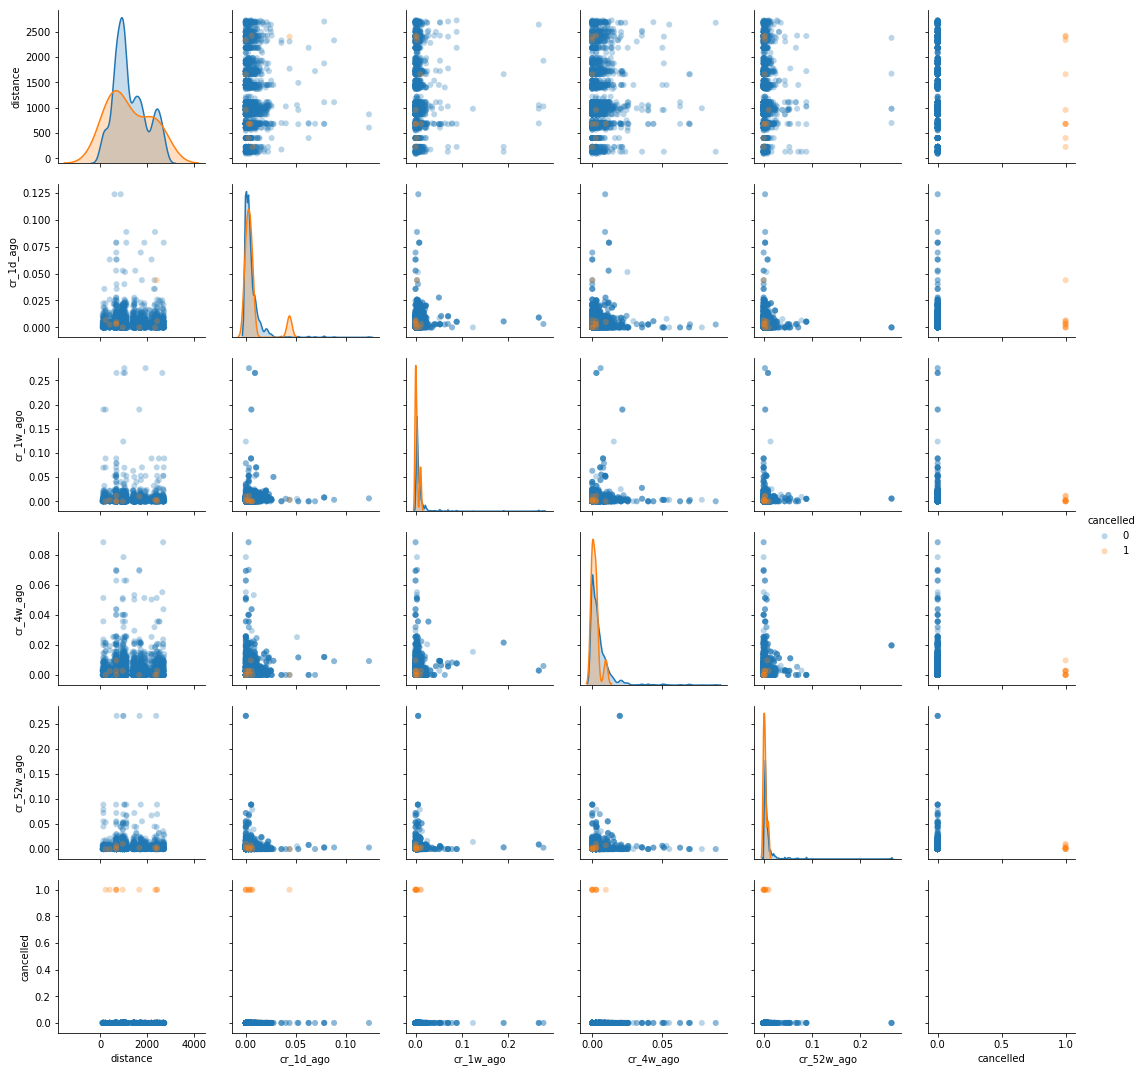

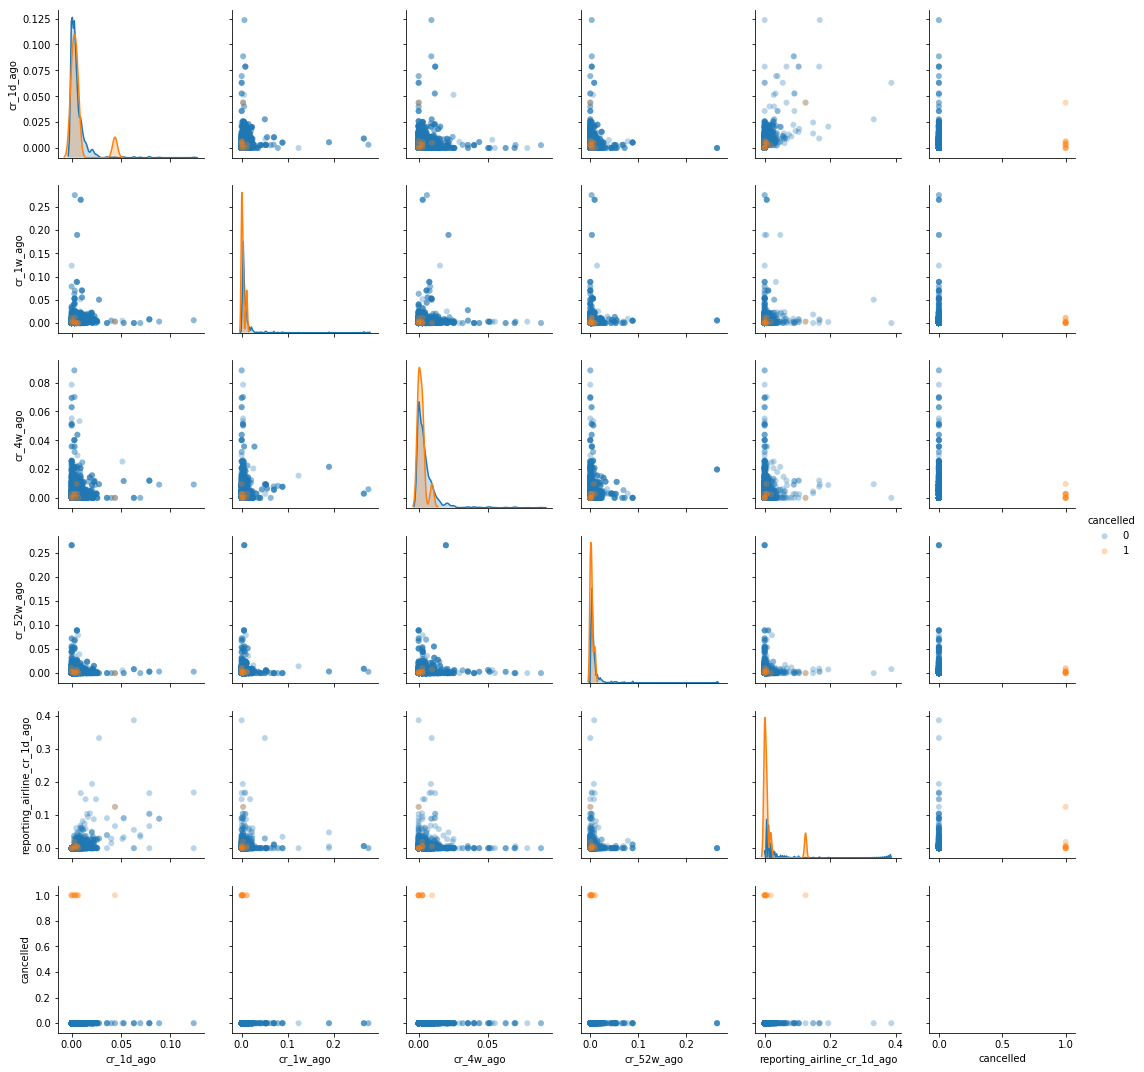

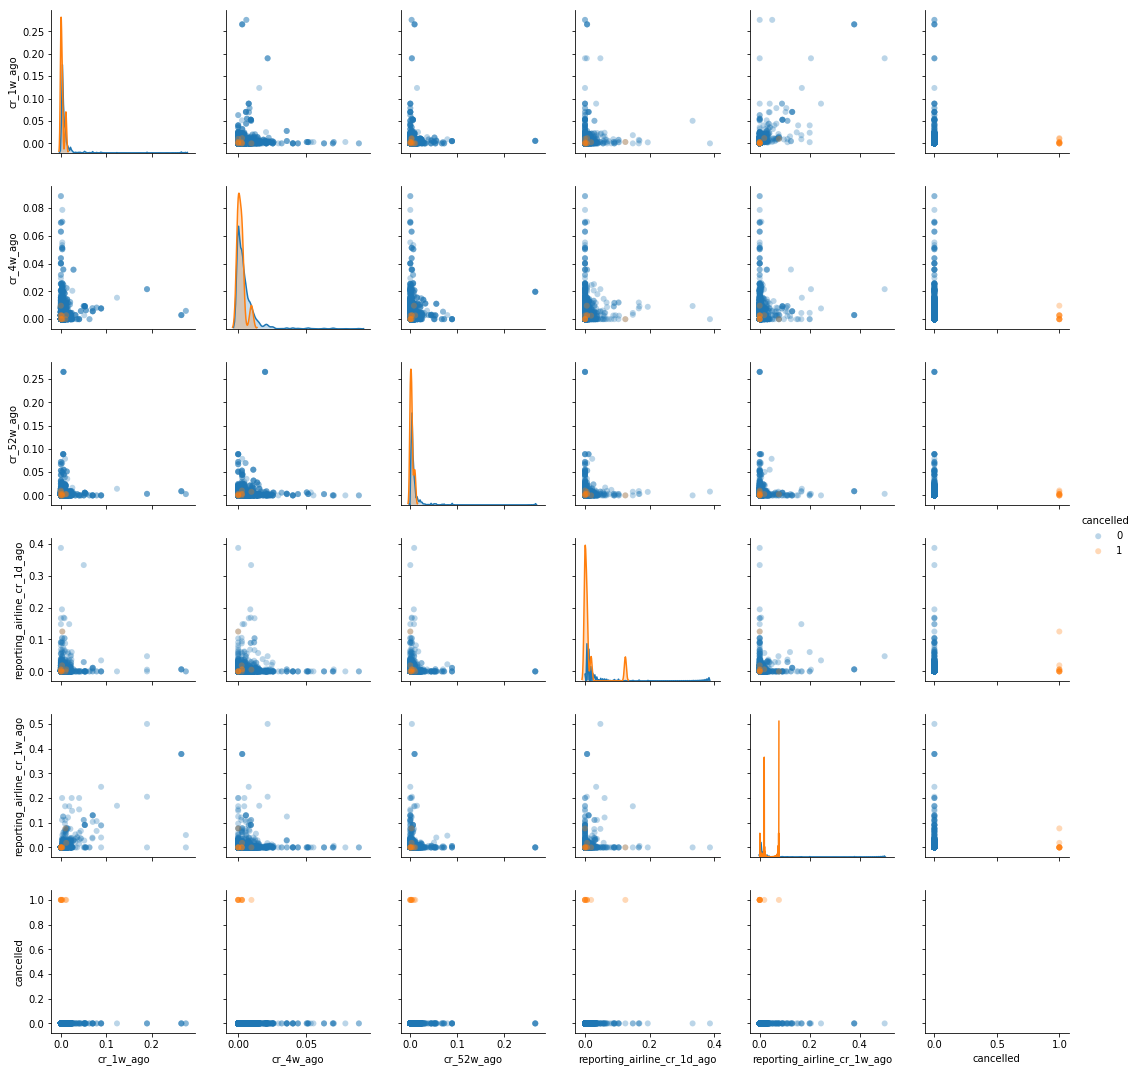

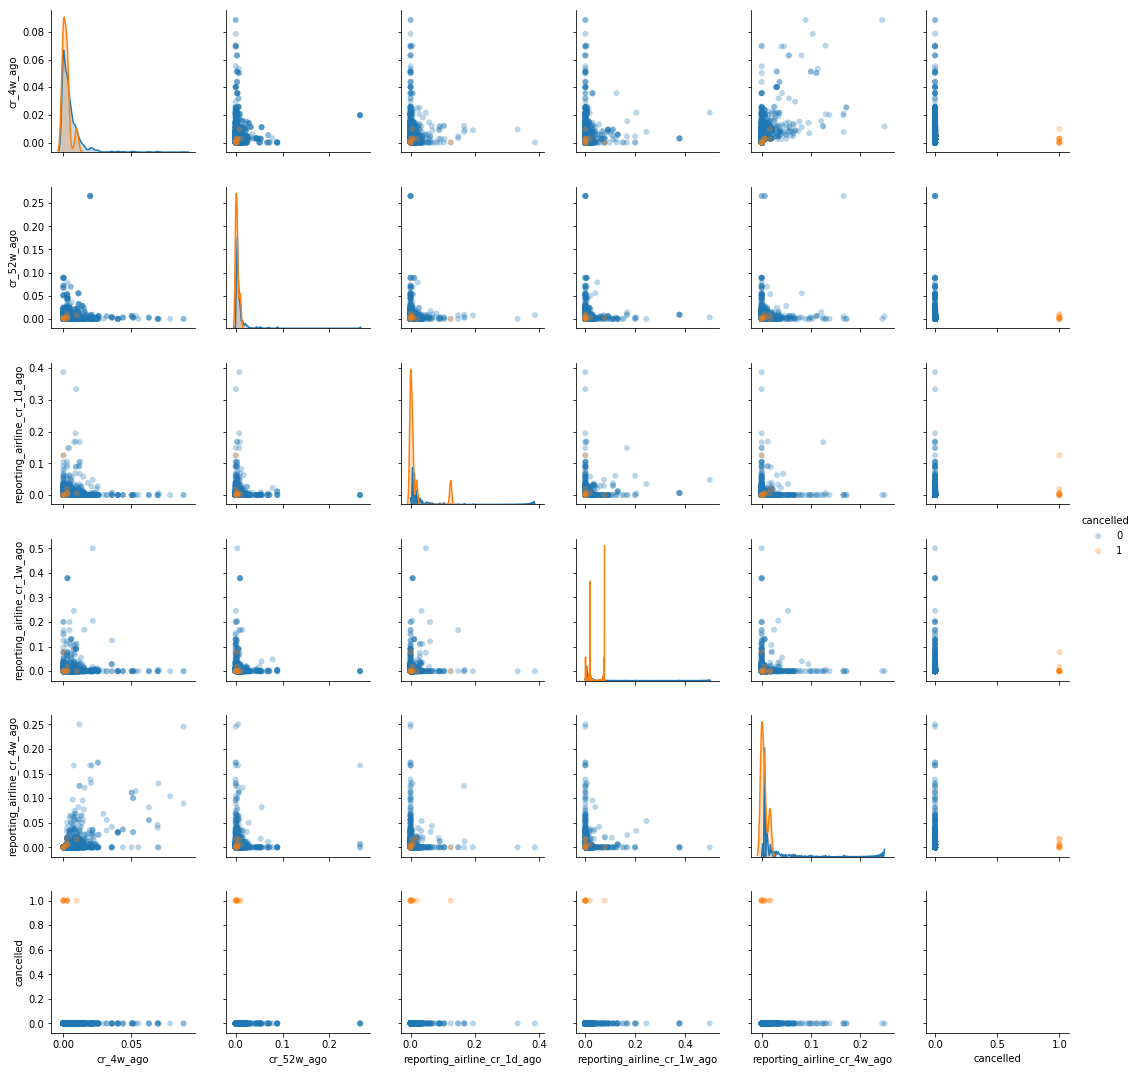

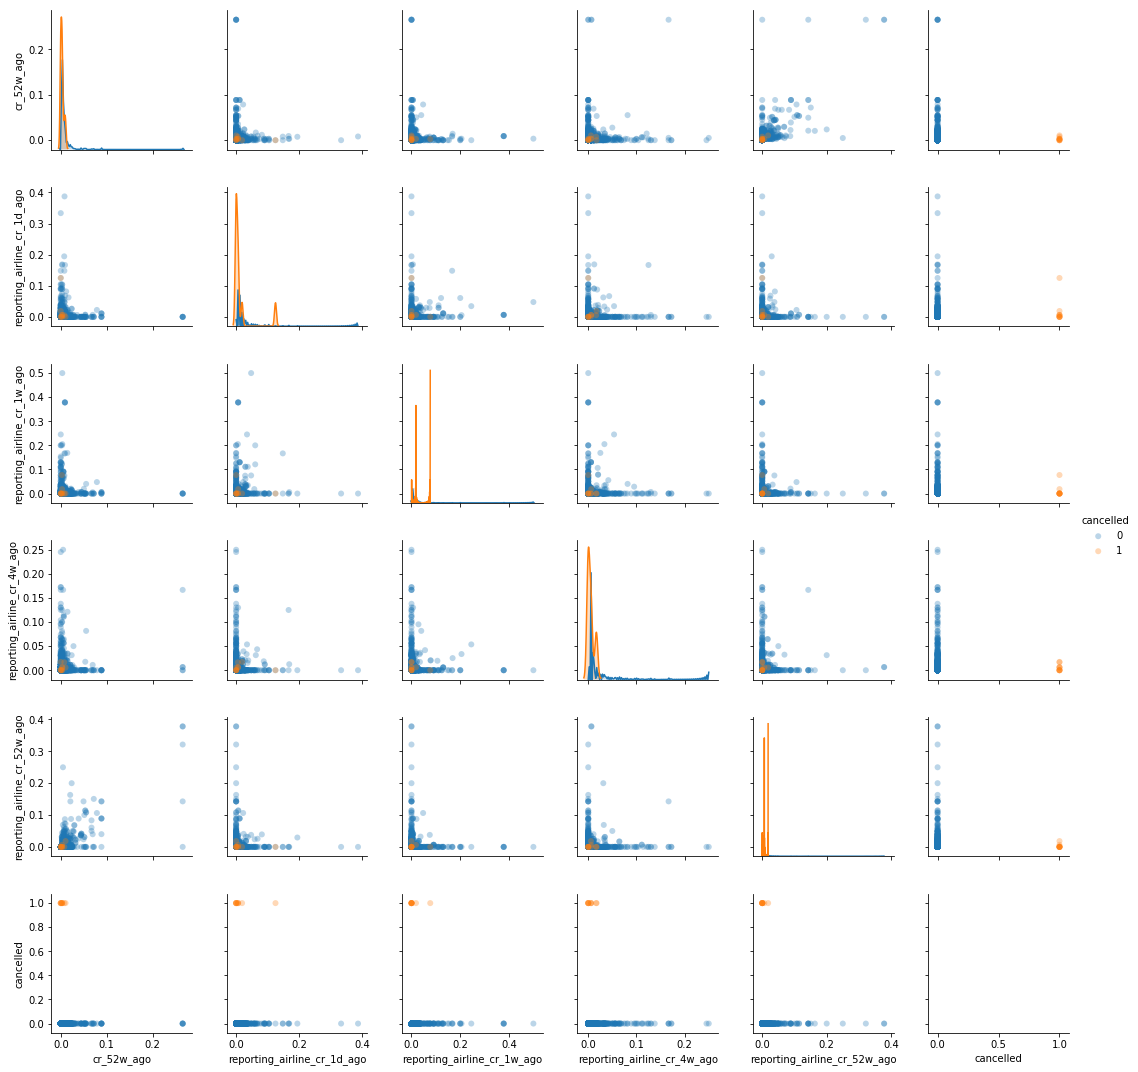

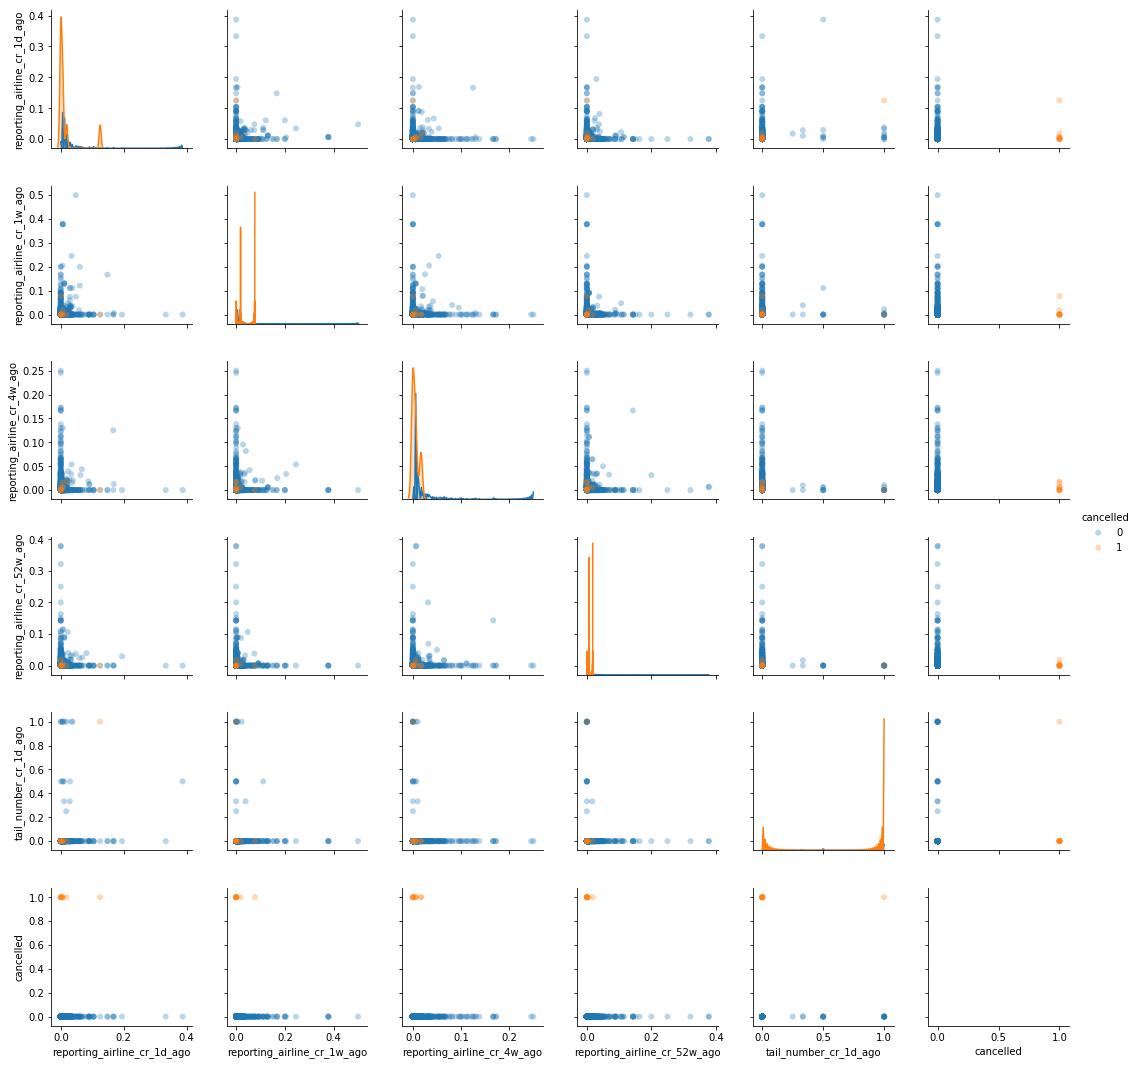

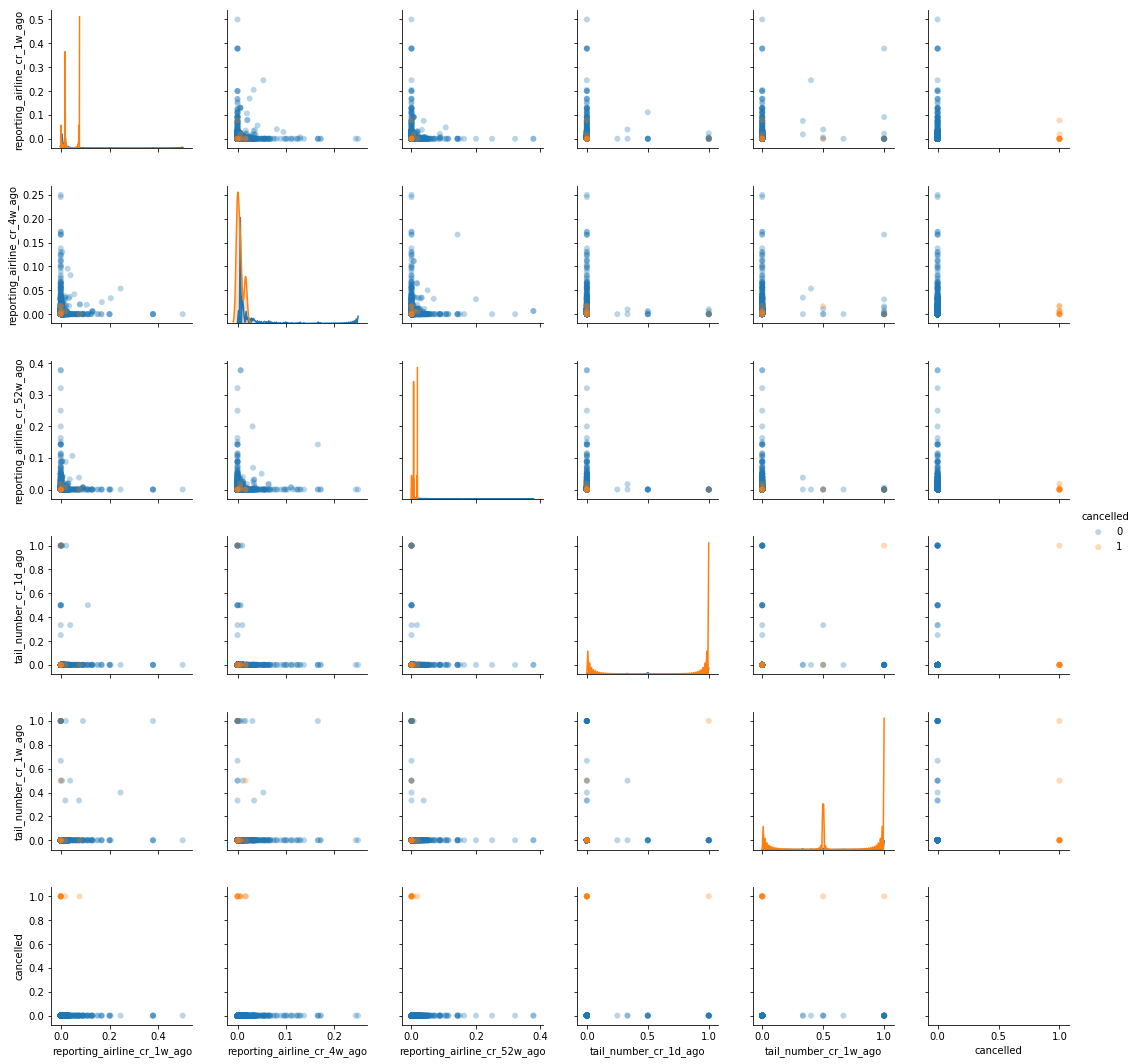

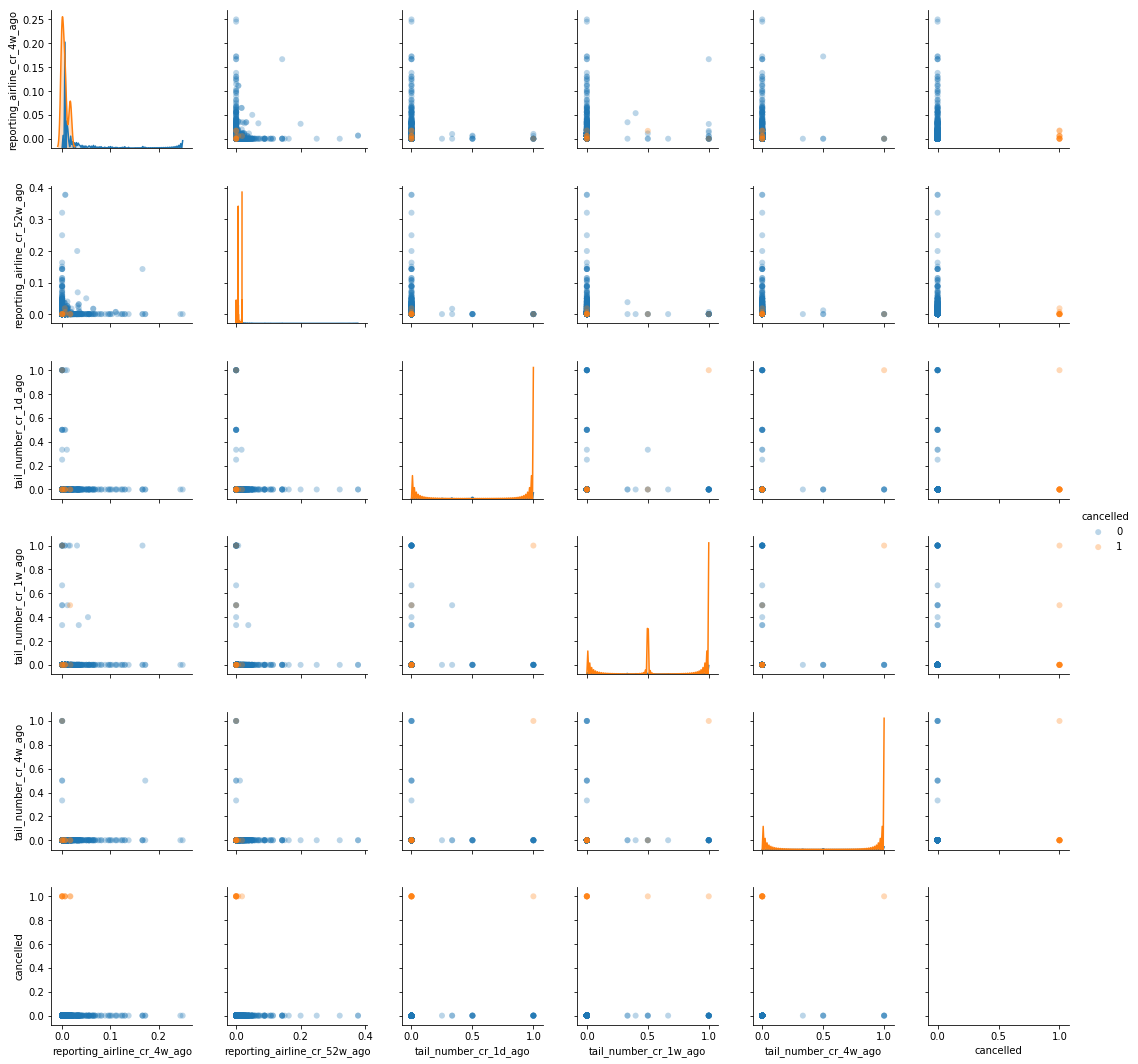

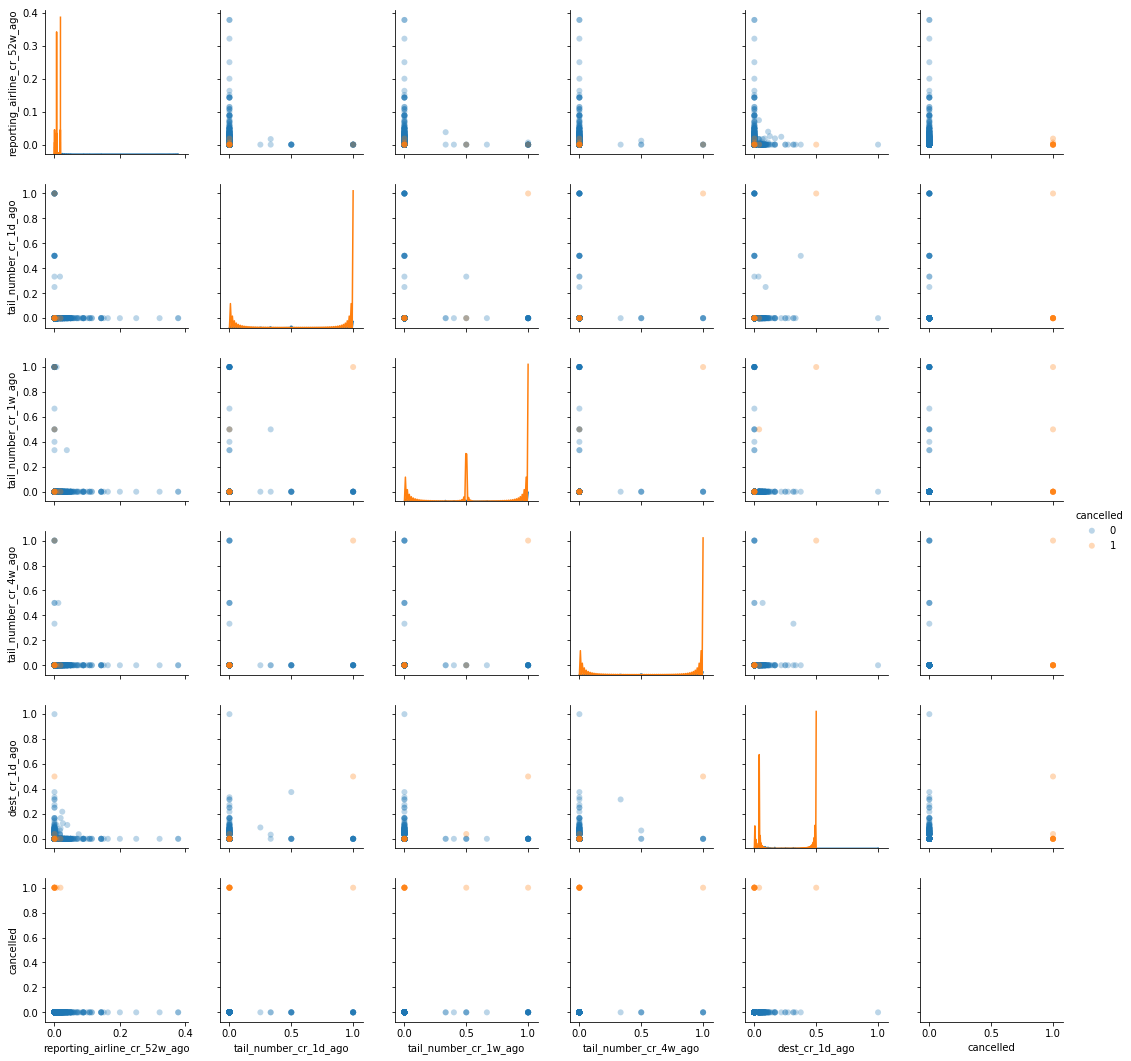

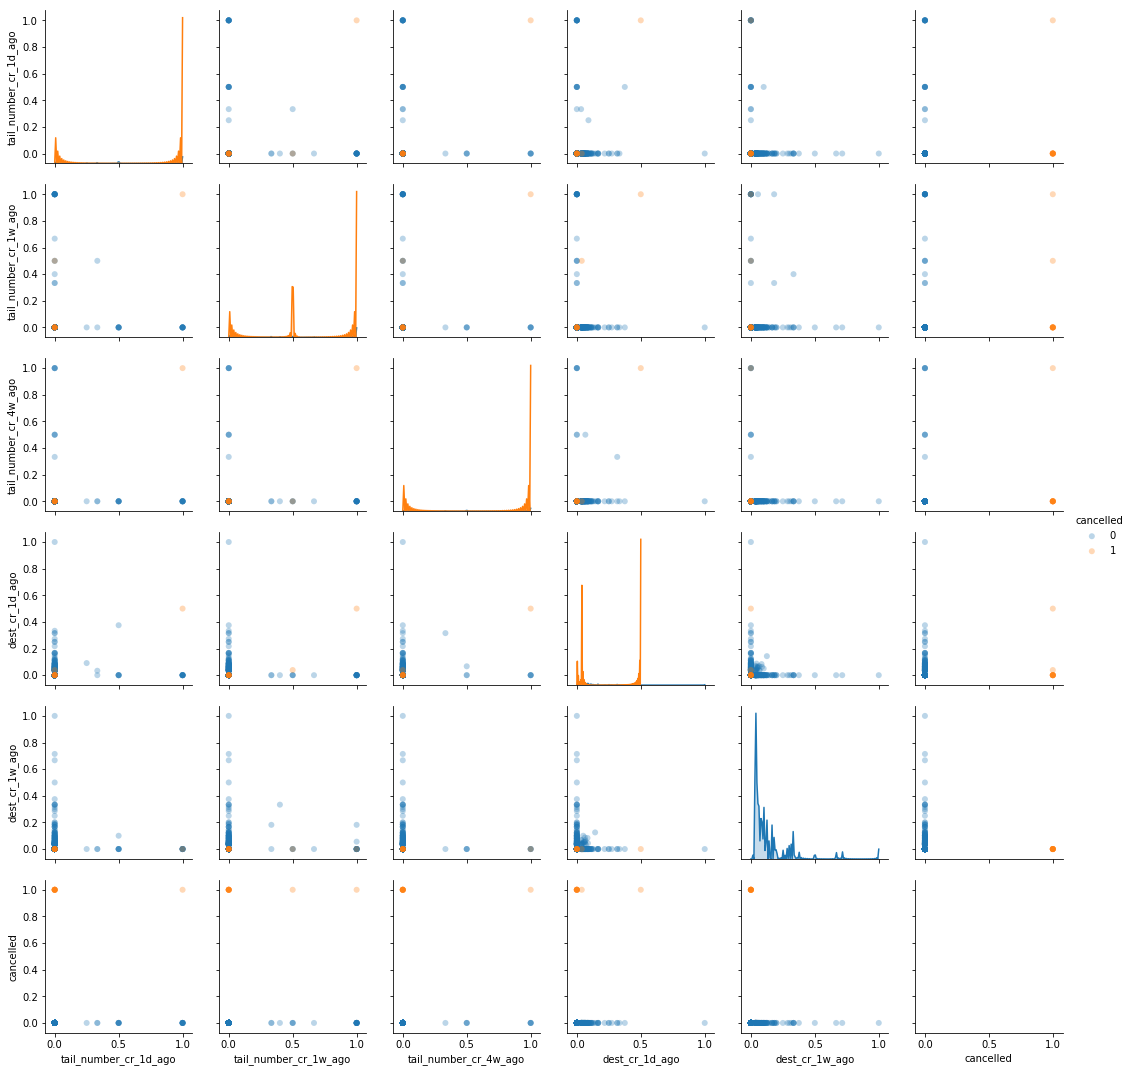

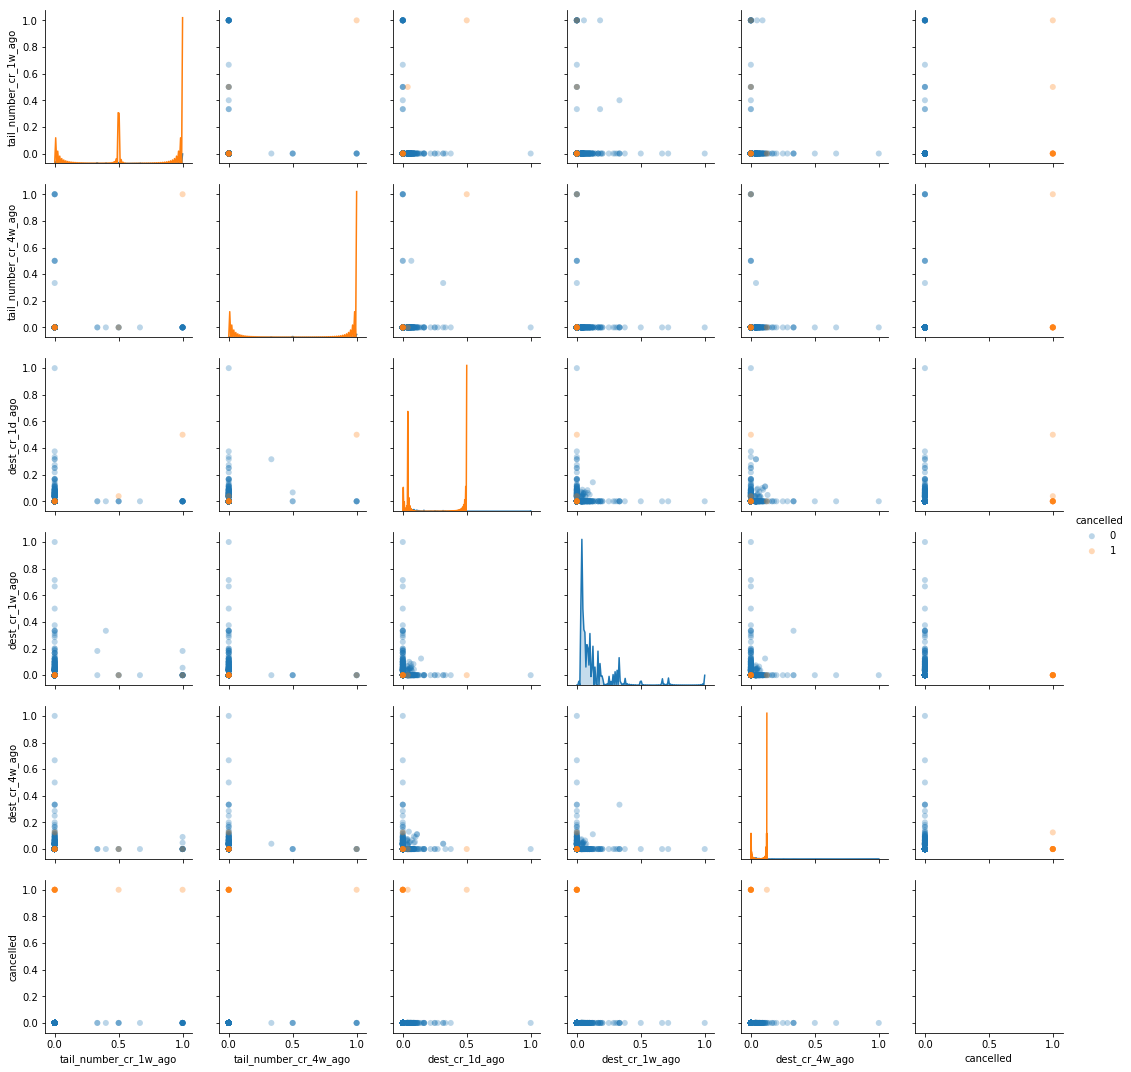

In [265]:
%time data = run()

*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [25]:
## %%writefile ../src/models/train_model.py

# Imports
import os
import time
import pickle

import numpy as np
import pandas as pd
from scipy import interp
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.model_selection import KFold, TimeSeriesSplit, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, neural_network, svm
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


# Helper functions
def file_exists(path, filename):
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    return file_exists


def record_results(results):
    """
    Keeps track of model results.
    Input: results (dict), a dictionary of key model attributes
        Results look like:
            results = {
                'Model': 'Logistic Regression', 
                'Notes': 'Classes highly unbalanced; added weather data'
                'Features': 31,
                'Target': 'Cancelled',
                'Train/Test Observations': (320132, 82433),
                'Train Balance': {0: 316931, 1: 3201},
                'Train Score': 0.3, 
                'Test Score': 0.21,
                'Train F1': 0.3,
                'Test F1': 0.2,
                'Hyperparameters': 'solver='lbfgs', 
            }
    Output: record returned as a dataframe and stored as a pickle to persist
    """
    path = '../models/records/'
    filename = 'model_history.pkl'
    filepath = path + filename
    
    if not file_exists(path, filename):
        # If records do not exist yet, create
        columns = list(results.keys())
        record = pd.DataFrame(columns=columns)
    else:
        record = pd.read_pickle(filepath)
        
    record.loc[len(record)] = results
#     display(record.tail(10))
    pd.to_pickle(record, filepath)
    return record


def cost_function(y_actual, y_pred, k=0.1):
    """
    Assigns a score to a set of predictions which represents the proportion of
    available margin that the model captures. A score of 1 indicates perfect
    predictions, capturing all possible savings. A score of zero means that
    following the model results in a wash (i.e. no change in revenue as
    compared to not using the model). A negative score indicates that using the
    model would lose money.
    
    Assigns cost for each prediction according to the following:
        FN: 0
        FP: k - profit / margin
        TN: 0
        TP: k
        
    Values for profit and margin are averages taken from market research, but
    could be improved on if made specific to type of aircraft.
    
    Input: 
        Actual and predicted classification values as lists or listlike objects
        k (default 0.1, i.e. 10%), the proportional improvement an airline can
        make with foreknowledge of a cancellation
    Output:
        A score ranging from {1 - profit/(margin * k), 1}
    """
    profit = 1800
    margin = 2600
    
    # Costs
    d = {
        0: {0: 0,
            1: k - profit / margin},
        1: {0: 0,
            1: k},
    }
    
    classifications = np.stack((y_actual, y_pred)).T
    savings = np.sum([d[a][p] for a, p in classifications])
    score = savings / (np.sum(y_actual) * k)
    return score
    

def save_to(filepath, item):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write)
    return


def build_model(method, kwargs={}):
    """
    Instantiates model with given method and hyperparameters
    Input: 
        method (str), name of model to instantiate
            Model options are:
            'KNN',
            'Logistic Regression',
            'Naive Bayes',
            'Linear SVM',
            'Radial SVM',
            'Random Forest',
            'Gradient Boosting',
            'Adaptive Boosting',
            'Linear MLP',
            'Relu MLP'
        kwargs (dict, optional), dictionary of model hyperparameters. If
            omitted, will use defaults.
    Output: instantiated model
    """
    if not kwargs:
        if method == 'Linear MLP':
            kwargs = {'activation': 'identity'}
    
    models = {
        'Logistic Regression': LogisticRegression,
        'KNN': neighbors.KNeighborsClassifier,
        'Naive Bayes': GaussianNB,
        'Linear SVM': svm.LinearSVC,
        'Radial SVM': svm.SVC,
        'Random Forest': RandomForestClassifier,
        'Gradient Boosting': GradientBoostingClassifier,
        'Adaptive Boosting': AdaBoostClassifier,
        'Linear MLP': neural_network.MLPClassifier,
        'Relu MLP': neural_network.MLPClassifier
    }
    model = eval('model(**kwargs)', {'model': models[method], 'kwargs': kwargs})
    
    return model


def save_train_test(cv, holdout, path):
    """
    Saves train and test data to pickles
    Input: train and test data and path to store pickles in
    Output: pickled files in directory
    """
    save_to(path + 'cv.pkl', cv)
    save_to(path + 'holdout.pkl', holdout)
    pass


def cv_roc_curve(tprs, aucs, mean_fpr, method):
    """
    """
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC Curve for {method}')
    plt.legend(loc="lower right")
    plt.show()
    return
    

def optimize_score(test_prob, y_test):
    scores = []
    for threshhold in np.linspace(0.5, 1, 50):
        test_pred = test_prob[:, 1] > threshhold
        score = cost_function(y_test, test_pred)
        scores.append(score)
        if max(scores) == score:
            top_thresh = threshhold
    return max(scores), top_thresh
    
def run_holdout(methods, holdout, target, desc, pipeline, threshhold):
    """
    """
    method, kwargs = list(methods.items())[0]
    t0 = time.time()
    
    print(f'\n Training {method} Models with {kwargs}...')
    start_method = time.time()
    t1 = time.time()

    t2 = time.time()
    X_train = holdout['X_train']
    y_train = holdout['y_train']
    X_test = holdout['X_test']
    y_test = holdout['y_test']

    # Train model
    model = build_model(method, kwargs=kwargs)
    model = CalibratedClassifierCV(model)
    model.fit(X_train, y_train)
    save_to('../models/model.pkl', model)

    # Predict and train on training set
    train_prob = model.predict_proba(X_train)
#     train_score, threshhold = optimize_score(train_prob, y_train)
    train_pred = train_prob[:, 1] > threshhold
    train_score = cost_function(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred)
    
    # Test model on testing set
    test_prob = model.predict_proba(X_test)
    test_pred = test_prob[:, 1] > threshhold
    test_score = cost_function(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)

    # Print status
    t3 = time.time() - t2
    print(f'Final test score: {test_score} with threshhold: {threshhold}')
    print(f'\n{round(t3/60, 1)} minutes.')

    # Log results
    train_cm = confusion_matrix(y_train, train_pred)
    test_cm = confusion_matrix(y_test, test_pred)
    results = {
        'Model': method, 
        'Desc': f'Thresh: {round(threshhold, 3)}. {desc}',
        'Features': X_train.shape[1],
        'Target': target,
        'Train/Test Observations': (X_train.shape[0], X_test.shape[0]),
        'Train Balance': dict(pd.value_counts(y_train)),
        'Train Score': train_score, 
        'Test Score': test_score,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Train CM': train_cm,
        'Test CM': test_cm,
        'Hyperparameters': model.get_params(), 
    }

    t4 = time.time() - t1
    print(f'\n{method} took {round(t4/60, 1)} minutes.')
    print(model)
    results = record_results(results)
    display(results.tail(1))
    try:
        k_best_cols = pipeline.named_steps['selectkbest'].get_support()
        if method in ['Logistic Regression', 'Linear MLP', 'Relu MLP']:
            coefficients = model.coef_[0]
        elif method in ['Random Forest', 'Gradient Boosting', 'Adaptive Boosting']:
            coefficients = model.feature_importances_
        feature_performance = pd.DataFrame({
            'Features': holdout[-1]['train'].drop('cancelled', axis=1).columns[k_best_cols],
            'Coefficients': coefficients}).sort_values(by='Coefficients', ascending=False)
        display(feature_performance)
    except:
        print("Can't display coefficients for this model")
    t5 = time.time() - t0
    print(f'Modeling took {round(t5/60)} minutes.')
    return
    

def run_models(methods, cv, target, desc, pipeline):
    """
    """
    t0 = time.time()
    for method, kwargs in methods.items():
        train_scores = []
        test_scores = []
        train_f1s = []
        test_f1s = []
        best_thresh = []

        # ROC-AUC params
        tprs = []
        aucs = []
        thresh = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure(figsize=(8, 6))

        print(f'\n Training {method} Models with {kwargs}...')
        start_method = time.time()
        t1 = time.time()

        for i, fold in enumerate(cv):
            t2 = time.time()
            X_train = fold['X_train']
            y_train = fold['y_train']
            X_test = fold['X_test']
            y_test = fold['y_test']

            model = build_model(method, kwargs=kwargs)

            prob_methods = ['Linear SVM', 'Radial SVM', 'Adaptive Boosting']
            if method in prob_methods:
                model = CalibratedClassifierCV(model)

            # Train model
            model.fit(X_train, y_train)
            save_to('../models/model.pkl', model)

            # Predict and train on training set
            train_pred = model.predict(X_train)
            train_prob = model.predict_proba(X_train)
            score, threshhold = optimize_score(train_prob, y_train)
            train_pred = train_prob[:, 1] > threshhold
            train_scores.append(score)
            train_f1s.append(f1_score(y_train, train_pred))

            # Test model on testing set
            test_pred = model.predict(X_test)
            test_prob = model.predict_proba(X_test)
            test_pred = test_prob[:, 1] > threshhold
            score = cost_function(y_test, test_pred)
#             score, threshhold = optimize_score(test_prob, y_test)
#             test_pred = test_prob[:, 1] > threshhold
            test_scores.append(score)
            best_thresh.append(threshhold)
            test_f1s.append(f1_score(y_test, test_pred))

            # Print status
            t3 = time.time() - t2
            print(f'CV {i + 1} test score: {score} with threshhold: {threshhold}')
            print(f'\n{round(t3/60, 1)} minutes.')

            # ROC-AUC scores
            fpr, tpr, thresholds = roc_curve(y_test, test_prob[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            thresh.append(thresholds[0])
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        # Log results
        train_cm = confusion_matrix(y_train, train_pred)
        test_cm = confusion_matrix(y_test, test_pred)
        train_score = np.mean(train_scores)
        test_score = np.mean(test_scores)
        train_f1 = np.mean(train_f1s)
        test_f1 = np.mean(test_f1s)
        opt_thresh = np.mean(best_thresh)
        results = {
            'Model': method, 
            'Desc': f'Thresh: {round(opt_thresh, 3)}. {desc}',
            'Features': X_train.shape[1],
            'Target': target,
            'Train/Test Observations': (X_train.shape[0], X_test.shape[0]),
            'Train Balance': dict(pd.value_counts(y_train)),
            'Train Score': train_score, 
            'Test Score': test_score,
            'Train F1': train_f1,
            'Test F1': test_f1,
            'Train CM': train_cm,
            'Test CM': test_cm,
            'Hyperparameters': model.get_params(), 
        }

        cv_roc_curve(tprs, aucs, mean_fpr, method)
        plt.savefig('../reports/figures/roc-auc.png')
        print(f'Mean threshold of {np.mean(thresh)} from:\n{thresh}')

        t4 = time.time() - t1
        print(f'\n{method} took {round(t4/60, 1)} minutes.')
        print(model)
        results = record_results(results)
        display(results.tail(1))
        try:
            k_best_cols = pipeline.named_steps['selectkbest'].get_support()
            if method in ['Logistic Regression', 'Linear MLP', 'Relu MLP']:
                coefficients = model.coef_[0]
            elif method in ['Random Forest', 'Gradient Boosting', 'Adaptive Boosting']:
                coefficients = model.feature_importances_
            feature_performance = pd.DataFrame({
                'Features': cv[-1]['train'].drop('cancelled', axis=1).columns[k_best_cols],
                'Coefficients': coefficients}).sort_values(by='Coefficients', ascending=False)
            display(feature_performance)
        except:
            print("Can't display coefficients for this model")
    t5 = time.time() - t0
    print(f'Modeling took {round(t5/60)} minutes.')
    return opt_thresh


def split_reduce(data, target, pipeline):
    """
    Splits a dictionary of train/test data into X and y and passes it through
    a feature preparation pipeline.
    Input: data dict of the form 
        {
            'train': train, 
            'test': test
            }
    Output: data dict containing transformed and reduced data of the form:
        {
            'train': train, 
            'test': test,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            }
    """
    train, test = data['train'], data['test']
    
    X_train, y_train = train.drop(target, axis=1), train[target]
    X_test, y_test = test.drop(target, axis=1), test[target]
    
    X_train = pipeline.fit_transform(X_train, y_train)
    X_test = pipeline.transform(X_test)
    save_to('../models/pipeline.pkl', pipeline)
    
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_test'] = X_test
    data['y_test'] = y_test
    
    return data
    
def prepare_data(cv, holdout, target, pipeline, final=1):
    """
    Splits cv and holdout data into X and y and processes X according to a data
    prep pipeline
    Input: 
        cv (list), a list of dictionaries of train/test folds
        holdout (dict), a holdout dataset for the final train/test
        target (str), the target variable
        pipeline (obj), an sklearn pipeline for processing the data
    Output: prepared forms of the cv and holdout datasets
    """
    for i, fold in enumerate(cv):
        print(f'Processing CV dataset {i + 1}...')
        fold = split_reduce(fold, target, pipeline)
    if final:
        print('Processing holdout dataset...')
        holdout = split_reduce(holdout, target, pipeline)
    return cv, holdout, pipeline
    

def train_test_split(data):
    """
    """
    start = data.index[0].year
    end = data.index[-1].year
    
    cv = []
    for i in range(start + 5, end - 1):
        cv_train = data[str(i - 5):str(i)]
        cv_test = data[str(i + 1)]
        cv.append({'train': cv_train, 'test': cv_test})
        
    ho_train = data[str(end - 6):str(end - 1)]
    ho_test = data[str(end)]
    holdout = {'train': ho_train, 'test': ho_test}
        
    return cv, holdout


def load_features(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data


def load_from(filepath):
    """
    Unpickles item and returns item from path
    Input: filepath to pickled object
    Output: unpickled object
    """
    with open(filepath, 'rb') as f:
        item = pickle.load(f)
    return item


def run(overwrite='ask', desc=''):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    # Parameters
    path = '../data/processed/'
    target = 'cancelled'
    methods = {
#         'Logistic Regression': {'penalty': 'l2', 'solver': 'lbfgs'},
#         'Logistic Regression': {'penalty': 'l1', 'solver': 'saga'},
#         'KNN': {},
# #        'Naive Bayes': {},
# #        'Linear SVM': {},
#         'Radial SVM': {},
        'Random Forest': {'n_estimators': 200, 
                          'oob_score': False, 
                          'n_jobs': 3,
                          'class_weight': 'balanced',
                         },
# #        'Gradient Boosting': {},
#         'Adaptive Boosting': {'n_estimators': 100},
#         'Linear MLP': {},
#         'Relu MLP': {}
    }

    score_func = f_classif
    for f in [20]:#, 20]:#, 20, 40]:
        for k in [12]:        
            
            pipeline = make_pipeline(
                StandardScaler(),
                PCA(n_components=f),
                SelectKBest(score_func, k=k)
            )
            if k >= f:
                pipeline = make_pipeline(
                    StandardScaler(),
                    SelectKBest(score_func, k=k)
                )

            overwrite = 'n'

            if overwrite == 'ask':
                overwrite = input(f'Reprocess data? y/n: ')
            if overwrite.lower() != 'y':  
                print(f'Loading CV data from {path}cv.pkl')
                cv = load_from(path + 'cv.pkl')
                holdout = load_from(path + 'holdout.pkl')
            else:
                # Load data
                print(f'Loading data from {path}data.pkl')
                data = load_from(path + 'data.pkl')

                # Train-test split
                cv, holdout = train_test_split(data)

                # Prepare data for model
                print(f'Preparing data for modeling with k = {k}, f = {f}...')
                cv, holdout, pipeline = prepare_data(cv, holdout, target, pipeline)

                # Pickle data
                save_to(path + 'cv.pkl', cv)
                save_to(path + 'holdout.pkl', holdout)

            # Cross validate models using defined methods
            if not desc:
                desc = input('Describe this run: ')
            desc = f'CVT - k{k}, f{f}: {desc}'

            threshhold = run_models(methods, cv, target, desc, pipeline)
    run_holdout(methods, holdout, target, desc, pipeline, threshhold)

    record = pd.read_pickle('../models/records/model_history.pkl')
    print('Last 5:')
    display(record.tail())
    top_5 = record.sort_values(by='Test Score', ascending=False)
    print('Top 5 so far:')
    display(top_5[top_5['Desc'].str.contains('CVT')].head())
    
    return #data, model, cv_test, X_test, y_test, predictions, test_score, results


In [32]:
data = load_from('../data/processed/data.pkl')
data.to_sql('dm', engine, if_exists='replace', index=True)

## Run model suite

Loading data from ../data/processed/data.pkl
Preparing data for modeling with k = 12, f = 20...
Processing CV dataset 1...
Processing CV dataset 2...
Processing CV dataset 3...
Processing CV dataset 4...
Processing CV dataset 5...
Processing holdout dataset...

 Training Relu MLP Models with {}...
CV 1 test score: 0.2585751978891821 with threshhold: 0.7857142857142857

1.2 minutes.
CV 2 test score: 0.3520518358531318 with threshhold: 0.6122448979591837

1.1 minutes.
CV 3 test score: 0.25794015054158254 with threshhold: 0.8673469387755102

1.2 minutes.
CV 4 test score: 0.25647668393782386 with threshhold: 0.9183673469387754

1.2 minutes.
CV 5 test score: 0.14236706689536877 with threshhold: 0.9693877551020408

1.2 minutes.


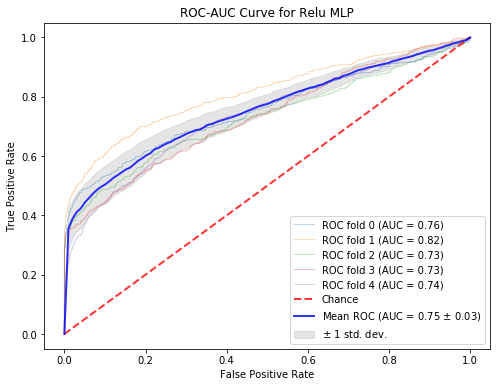

Mean threshold of 1.9991256063774572 from:
[1.9989807188198871, 1.9968194178028398, 1.9999793429298314, 1.9998591888603707, 1.9999893634743557]

Relu MLP took 5.9 minutes.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


Model                                               Desc Features  \
393  Relu MLP  Thresh: 0.831. CVT - k12, f20: Final test (usi...       12   

        Target Train/Test Observations         Train Balance  Train Score  \
393  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333402   

     Test Score  Train F1   Test F1                    Train CM  \
393    0.253482  0.499605  0.403226  [[599624, 0], [1682, 755]]   

                      Test CM  \
393  [[118728, 0], [500, 83]]   

                                       Hyperparameters  
393  {'activation': 'relu', 'alpha': 0.0001, 'batch...

Can't display coefficients for this model
Modeling took 6 minutes.

 Training Relu MLP Models with {}...
Final test score: 0.08014571948998177 with threshhold: 0.8306122448979592

1.2 minutes.

Relu MLP took 1.2 minutes.
CalibratedClassifierCV(base_estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
            cv='warn', method='sigmoid')


Model                                               Desc Features  \
394  Relu MLP  Thresh: 0.831. CVT - k12, f20: Final test (usi...       12   

        Target Train/Test Observations         Train Balance  Train Score  \
394  cancelled        (629720, 120975)  {0: 627157, 1: 2563}      0.25556   

     Test Score  Train F1   Test F1                    Train CM  \
394    0.080146  0.407085  0.148398  [[627157, 0], [1908, 655]]   

                      Test CM  \
394  [[120426, 0], [505, 44]]   

                                       Hyperparameters  
394  {'base_estimator__activation': 'relu', 'base_e...

Can't display coefficients for this model
Modeling took 1 minutes.
Last 5:


Model                                               Desc Features  \
390  Relu MLP           Thresh: 0.939. CVT - k4, f20: Final RELU        4   
391  Relu MLP           Thresh: 0.886. CVT - k4, f20: Final RELU        4   
392  Relu MLP           Thresh: 0.886. CVT - k4, f20: Final RELU        4   
393  Relu MLP  Thresh: 0.831. CVT - k12, f20: Final test (usi...       12   
394  Relu MLP  Thresh: 0.831. CVT - k12, f20: Final test (usi...       12   

        Target Train/Test Observations         Train Balance  Train Score  \
390  cancelled        (629720, 120975)  {0: 627157, 1: 2563}     0.000000   
391  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333173   
392  cancelled        (629720, 120975)  {0: 627157, 1: 2563}     0.000000   
393  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333402   
394  cancelled        (629720, 120975)  {0: 627157, 1: 2563}     0.255560   

     Test Score  Train F1   Test F1                    Train CM  \
390    0.000000  0.000000  0.000000    [[627157, 0], [2563, 0]]   
391    0.254518  0.499344  0.404534  [[599624, 0], [1683, 754]]   
392    0.000000  0.000000  0.000000    [[627157, 0], [2563, 0]]   
393    0.253482  0.499605  0.403226  [[599624, 0], [1682, 755]]   
394    0.080146  0.407085  0.148398  [[627157, 0], [1908, 655]]   

                      Test CM  \
390   [[120426, 0], [549, 0]]   
391  [[118728, 0], [500, 83]]   
392   [[120426, 0], [549, 0]]   
393  [[118728, 0], [500, 83]]   
394  [[120426, 0], [505, 44]]   

                                       Hyperparameters  
390  {'base_estimator__activation': 'relu', 'base_e...  
391  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
392  {'base_estimator__activation': 'relu', 'base_e...  
393  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
394  {'base_estimator__activation': 'relu', 'base_e...

Top 5 so far:


Model                                               Desc Features  \
347  Relu MLP  Thresh: 0.843. CVT - k4, f20: CVT - k3, f20: C...        4   
342  Relu MLP  Thresh: 0.871. CVT - k3, f20: CVT - k15, f10: ...        3   
352  Relu MLP  Thresh: 0.961. CVT - k5, f20: CVT - k4, f20: C...        5   
389  Relu MLP             Thresh: 0.9. CVT - k4, f20: Final RELU        4   
385  Relu MLP  Thresh: 0.804. CVT - k12, f20: Final test (usi...       12   

        Target Train/Test Observations         Train Balance  Train Score  \
347  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333343   
342  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333218   
352  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332729   
389  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332383   
385  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332814   

     Test Score  Train F1   Test F1                    Train CM  \
347    0.257873  0.499544  0.405359  [[599624, 0], [1682, 755]]   
342    0.257346  0.499411  0.404694  [[599624, 0], [1680, 757]]   
352    0.257346  0.498874  0.404694  [[599624, 0], [1681, 756]]   
389    0.256914  0.498464  0.404220  [[599624, 0], [1683, 754]]   
385    0.256710  0.498946  0.403713  [[599624, 0], [1684, 753]]   

                      Test CM  \
347  [[118728, 0], [500, 83]]   
342  [[118728, 0], [500, 83]]   
352  [[118728, 0], [500, 83]]   
389  [[118728, 0], [500, 83]]   
385  [[118728, 0], [502, 81]]   

                                       Hyperparameters  
347  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
342  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
352  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
389  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
385  {'activation': 'relu', 'alpha': 0.0001, 'batch...

<Figure size 432x288 with 0 Axes>

In [23]:
run(desc='Final test (using CV threshhold)')

Loading CV data from ../data/processed/cv.pkl

 Training Random Forest Models with {'n_estimators': 200, 'oob_score': False, 'n_jobs': 3, 'class_weight': 'balanced'}...
CV 1 test score: 0.25329815303430087 with threshhold: 0.5204081632653061

4.2 minutes.
CV 2 test score: 0.32430636318325307 with threshhold: 0.5102040816326531

4.6 minutes.
CV 3 test score: 0.25794015054158254 with threshhold: 0.5

4.4 minutes.
CV 4 test score: 0.26424870466321243 with threshhold: 0.5204081632653061

4.7 minutes.
CV 5 test score: 0.11861723182477897 with threshhold: 0.5102040816326531

4.8 minutes.


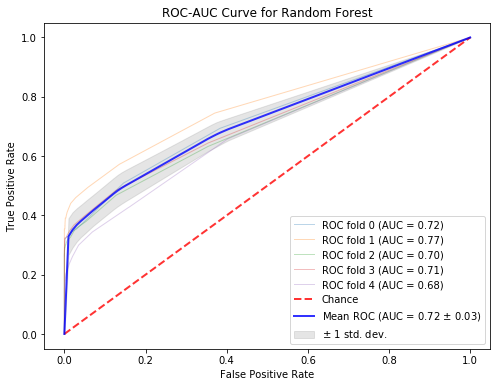

Mean threshold of 2.0 from:
[2.0, 2.0, 2.0, 2.0, 2.0]

Random Forest took 22.8 minutes.
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


Model                                          Desc Features  \
395  Random Forest  Thresh: 0.512. CVT - k12, f20: Random Forest       12   

        Target Train/Test Observations         Train Balance  Train Score  \
395  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.991887   

     Test Score  Train F1  Test F1                  Train CM  \
395    0.243682  0.999282  0.40184  [[599620, 4], [1, 2436]]   

                      Test CM  \
395  [[118726, 2], [502, 81]]   

                                       Hyperparameters  
395  {'bootstrap': True, 'class_weight': 'balanced'...

Can't display coefficients for this model
Modeling took 23 minutes.

 Training Random Forest Models with {'n_estimators': 200, 'oob_score': False, 'n_jobs': 3, 'class_weight': 'balanced'}...
Final test score: -0.14642006445285136 with threshhold: 0.5122448979591836

8.2 minutes.

Random Forest took 8.2 minutes.
CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
            cv='warn', method='sigmoid')


Model                                          Desc Features  \
396  Random Forest  Thresh: 0.512. CVT - k12, f20: Random Forest       12   

        Target Train/Test Observations         Train Balance  Train Score  \
396  cancelled        (629720, 120975)  {0: 627157, 1: 2563}     0.972568   

     Test Score  Train F1   Test F1                   Train CM  \
396    -0.14642   0.99492  0.143322  [[627148, 9], [17, 2546]]   

                       Test CM  \
396  [[120405, 21], [505, 44]]   

                                       Hyperparameters  
396  {'base_estimator__bootstrap': True, 'base_esti...

Can't display coefficients for this model
Modeling took 8 minutes.
Last 5:


Model                                               Desc  \
392       Relu MLP           Thresh: 0.886. CVT - k4, f20: Final RELU   
393       Relu MLP  Thresh: 0.831. CVT - k12, f20: Final test (usi...   
394       Relu MLP  Thresh: 0.831. CVT - k12, f20: Final test (usi...   
395  Random Forest       Thresh: 0.512. CVT - k12, f20: Random Forest   
396  Random Forest       Thresh: 0.512. CVT - k12, f20: Random Forest   

    Features     Target Train/Test Observations         Train Balance  \
392        4  cancelled        (629720, 120975)  {0: 627157, 1: 2563}   
393       12  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
394       12  cancelled        (629720, 120975)  {0: 627157, 1: 2563}   
395       12  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
396       12  cancelled        (629720, 120975)  {0: 627157, 1: 2563}   

     Train Score  Test Score  Train F1   Test F1                    Train CM  \
392     0.000000    0.000000  0.000000  0.000000    [[627157, 0], [2563, 0]]   
393     0.333402    0.253482  0.499605  0.403226  [[599624, 0], [1682, 755]]   
394     0.255560    0.080146  0.407085  0.148398  [[627157, 0], [1908, 655]]   
395     0.991887    0.243682  0.999282  0.401840    [[599620, 4], [1, 2436]]   
396     0.972568   -0.146420  0.994920  0.143322   [[627148, 9], [17, 2546]]   

                       Test CM  \
392    [[120426, 0], [549, 0]]   
393   [[118728, 0], [500, 83]]   
394   [[120426, 0], [505, 44]]   
395   [[118726, 2], [502, 81]]   
396  [[120405, 21], [505, 44]]   

                                       Hyperparameters  
392  {'base_estimator__activation': 'relu', 'base_e...  
393  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
394  {'base_estimator__activation': 'relu', 'base_e...  
395  {'bootstrap': True, 'class_weight': 'balanced'...  
396  {'base_estimator__bootstrap': True, 'base_esti...

Top 5 so far:


Model                                               Desc Features  \
347  Relu MLP  Thresh: 0.843. CVT - k4, f20: CVT - k3, f20: C...        4   
352  Relu MLP  Thresh: 0.961. CVT - k5, f20: CVT - k4, f20: C...        5   
342  Relu MLP  Thresh: 0.871. CVT - k3, f20: CVT - k15, f10: ...        3   
389  Relu MLP             Thresh: 0.9. CVT - k4, f20: Final RELU        4   
385  Relu MLP  Thresh: 0.804. CVT - k12, f20: Final test (usi...       12   

        Target Train/Test Observations         Train Balance  Train Score  \
347  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333343   
352  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332729   
342  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333218   
389  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332383   
385  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332814   

     Test Score  Train F1   Test F1                    Train CM  \
347    0.257873  0.499544  0.405359  [[599624, 0], [1682, 755]]   
352    0.257346  0.498874  0.404694  [[599624, 0], [1681, 756]]   
342    0.257346  0.499411  0.404694  [[599624, 0], [1680, 757]]   
389    0.256914  0.498464  0.404220  [[599624, 0], [1683, 754]]   
385    0.256710  0.498946  0.403713  [[599624, 0], [1684, 753]]   

                      Test CM  \
347  [[118728, 0], [500, 83]]   
352  [[118728, 0], [500, 83]]   
342  [[118728, 0], [500, 83]]   
389  [[118728, 0], [500, 83]]   
385  [[118728, 0], [502, 81]]   

                                       Hyperparameters  
347  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
352  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
342  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
389  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
385  {'activation': 'relu', 'alpha': 0.0001, 'batch...

<Figure size 432x288 with 0 Axes>

In [26]:
run(desc='Random Forest')


Loading CV data from ../data/processed/cv.pkl

 Training Relu MLP Models with {}...
CV 1 test score: 0.2585751978891821 with threshhold: 0.8979591836734693

0.9 minutes.
CV 2 test score: 0.3520518358531318 with threshhold: 0.8979591836734693

1.0 minutes.
CV 3 test score: 0.25794015054158254 with threshhold: 0.9081632653061225

1.0 minutes.
CV 4 test score: 0.26165803108808294 with threshhold: 0.9897959183673469

1.0 minutes.
CV 5 test score: 0.1423670668953688 with threshhold: 0.7346938775510203

1.1 minutes.


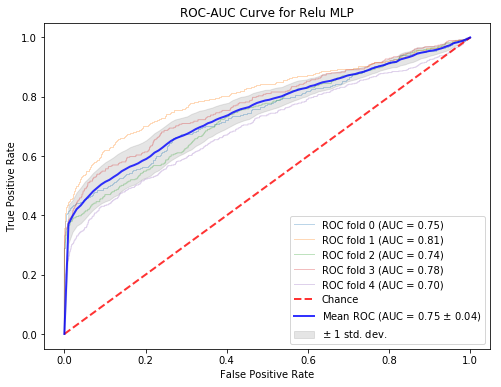

Mean threshold of 1.9992251660296347 from:
[1.9976890408984465, 1.9999012141971835, 1.9996376144494596, 1.999960399538219, 1.9989375610648645]

Relu MLP took 5.0 minutes.
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


Model                                      Desc Features     Target  \
391  Relu MLP  Thresh: 0.886. CVT - k4, f20: Final RELU        4  cancelled   

    Train/Test Observations         Train Balance  Train Score  Test Score  \
391        (602061, 119311)  {0: 599624, 1: 2437}     0.333173    0.254518   

     Train F1   Test F1                    Train CM                   Test CM  \
391  0.499344  0.404534  [[599624, 0], [1683, 754]]  [[118728, 0], [500, 83]]   

                                       Hyperparameters  
391  {'activation': 'relu', 'alpha': 0.0001, 'batch...

Can't display coefficients for this model
Modeling took 5 minutes.

 Training Relu MLP Models with {}...
Final test score: 0.0 with threshhold: 0.8857142857142858

0.8 minutes.

Relu MLP took 0.8 minutes.
CalibratedClassifierCV(base_estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
            cv='warn', method='sigmoid')


Model                                      Desc Features     Target  \
392  Relu MLP  Thresh: 0.886. CVT - k4, f20: Final RELU        4  cancelled   

    Train/Test Observations         Train Balance  Train Score  Test Score  \
392        (629720, 120975)  {0: 627157, 1: 2563}          0.0         0.0   

     Train F1  Test F1                  Train CM                  Test CM  \
392       0.0      0.0  [[627157, 0], [2563, 0]]  [[120426, 0], [549, 0]]   

                                       Hyperparameters  
392  {'base_estimator__activation': 'relu', 'base_e...

Can't display coefficients for this model
Modeling took 1 minutes.
Last 5:


Model                                         Desc Features  \
388  Random Forest  Thresh: 0.51. CVT - k12, f20: Random Forest       12   
389       Relu MLP       Thresh: 0.9. CVT - k4, f20: Final RELU        4   
390       Relu MLP     Thresh: 0.939. CVT - k4, f20: Final RELU        4   
391       Relu MLP     Thresh: 0.886. CVT - k4, f20: Final RELU        4   
392       Relu MLP     Thresh: 0.886. CVT - k4, f20: Final RELU        4   

        Target Train/Test Observations         Train Balance  Train Score  \
388  cancelled        (629720, 120975)  {0: 627157, 1: 2563}     0.978421   
389  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332383   
390  cancelled        (629720, 120975)  {0: 627157, 1: 2563}     0.000000   
391  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333173   
392  cancelled        (629720, 120975)  {0: 627157, 1: 2563}     0.000000   

     Test Score  Train F1   Test F1                    Train CM  \
388   -0.079865  0.997857  0.147783    [[627148, 9], [2, 2561]]   
389    0.256914  0.498464  0.404220  [[599624, 0], [1683, 754]]   
390    0.000000  0.000000  0.000000    [[627157, 0], [2563, 0]]   
391    0.254518  0.499344  0.404534  [[599624, 0], [1683, 754]]   
392    0.000000  0.000000  0.000000    [[627157, 0], [2563, 0]]   

                       Test CM  \
388  [[120411, 15], [504, 45]]   
389   [[118728, 0], [500, 83]]   
390    [[120426, 0], [549, 0]]   
391   [[118728, 0], [500, 83]]   
392    [[120426, 0], [549, 0]]   

                                       Hyperparameters  
388  {'base_estimator__bootstrap': True, 'base_esti...  
389  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
390  {'base_estimator__activation': 'relu', 'base_e...  
391  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
392  {'base_estimator__activation': 'relu', 'base_e...

Top 5 so far:


Model                                               Desc Features  \
347  Relu MLP  Thresh: 0.843. CVT - k4, f20: CVT - k3, f20: C...        4   
342  Relu MLP  Thresh: 0.871. CVT - k3, f20: CVT - k15, f10: ...        3   
352  Relu MLP  Thresh: 0.961. CVT - k5, f20: CVT - k4, f20: C...        5   
389  Relu MLP             Thresh: 0.9. CVT - k4, f20: Final RELU        4   
385  Relu MLP  Thresh: 0.804. CVT - k12, f20: Final test (usi...       12   

        Target Train/Test Observations         Train Balance  Train Score  \
347  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333343   
342  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333218   
352  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332729   
389  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332383   
385  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332814   

     Test Score  Train F1   Test F1                    Train CM  \
347    0.257873  0.499544  0.405359  [[599624, 0], [1682, 755]]   
342    0.257346  0.499411  0.404694  [[599624, 0], [1680, 757]]   
352    0.257346  0.498874  0.404694  [[599624, 0], [1681, 756]]   
389    0.256914  0.498464  0.404220  [[599624, 0], [1683, 754]]   
385    0.256710  0.498946  0.403713  [[599624, 0], [1684, 753]]   

                      Test CM  \
347  [[118728, 0], [500, 83]]   
342  [[118728, 0], [500, 83]]   
352  [[118728, 0], [500, 83]]   
389  [[118728, 0], [500, 83]]   
385  [[118728, 0], [502, 81]]   

                                       Hyperparameters  
347  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
342  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
352  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
389  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
385  {'activation': 'relu', 'alpha': 0.0001, 'batch...

<Figure size 432x288 with 0 Axes>

In [20]:
run(desc='Final RELU')


In [160]:
record = pd.read_pickle('../models/records/model_history.pkl')
for col in record.columns:
    print(record.iloc[290][col])

Random Forest
Thresh: 0.7387755102040815. CV - k: 12, f: 20: CV - k: 6, f: 20: Optimizing threshhold
12
cancelled
(875152, 119311)
{0: 871168, 1: 3984}
0.9958449309653084
0.25942780943872606
0.9980734921463952
0.4072998228699546
[[871168      0]
 [    17   3967]]
[[118728      0]
 [   500     83]]
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 2, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [153]:
record = pd.read_pickle('../models/records/model_history.pkl')
top_5 = record[record['Desc'].str.contains('CVT')].sort_values(by='Test Score', ascending=False)
display(top_5.head(8))

Model                                               Desc Features  \
347    Relu MLP  Thresh: 0.843. CVT - k4, f20: CVT - k3, f20: C...        4   
352    Relu MLP  Thresh: 0.961. CVT - k5, f20: CVT - k4, f20: C...        5   
342    Relu MLP  Thresh: 0.871. CVT - k3, f20: CVT - k15, f10: ...        3   
367    Relu MLP  Thresh: 0.859. CVT - k12, f20: CVT - k9, f20: ...       12   
362    Relu MLP  Thresh: 0.845. CVT - k9, f20: CVT - k7, f20: C...        9   
357    Relu MLP  Thresh: 0.867. CVT - k7, f20: CVT - k5, f20: C...        7   
351  Linear MLP  Thresh: 0.865. CVT - k5, f20: CVT - k4, f20: C...        5   
331  Linear MLP  Thresh: 0.873. CVT - k12, f10: CVT - k9, f10: ...       12   

        Target Train/Test Observations         Train Balance  Train Score  \
347  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333343   
352  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332729   
342  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333218   
367  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.332625   
362  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333269   
357  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.333150   
351  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.318384   
331  cancelled        (602061, 119311)  {0: 599624, 1: 2437}     0.321612   

     Test Score  Train F1   Test F1                     Train CM  \
347    0.257873  0.499544  0.405359   [[599624, 0], [1682, 755]]   
352    0.257346  0.498874  0.404694   [[599624, 0], [1681, 756]]   
342    0.257346  0.499411  0.404694   [[599624, 0], [1680, 757]]   
367    0.256141  0.499260  0.402987   [[599624, 0], [1684, 753]]   
362    0.254000  0.499459  0.403881   [[599624, 0], [1682, 755]]   
357    0.253146  0.499333  0.402418   [[599624, 0], [1684, 753]]   
351    0.250212  0.499152  0.405991  [[599611, 13], [1676, 761]]   
331    0.249970  0.499717  0.405981  [[599600, 24], [1671, 766]]   

                      Test CM  \
347  [[118728, 0], [500, 83]]   
352  [[118728, 0], [500, 83]]   
342  [[118728, 0], [500, 83]]   
367  [[118728, 0], [502, 81]]   
362  [[118728, 0], [500, 83]]   
357  [[118728, 0], [504, 79]]   
351  [[118728, 0], [499, 84]]   
331  [[118728, 0], [499, 84]]   

                                       Hyperparameters  
347  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
352  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
342  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
367  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
362  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
357  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
351  {'activation': 'identity', 'alpha': 0.0001, 'b...  
331  {'activation': 'identity', 'alpha': 0.0001, 'b...

In [154]:
record = pd.read_pickle('../models/records/model_history.pkl')
display(record.tail(15).sort_values(by='Test Score', ascending=False))


Model                                               Desc  \
367             Relu MLP  Thresh: 0.859. CVT - k12, f20: CVT - k9, f20: ...   
362             Relu MLP  Thresh: 0.845. CVT - k9, f20: CVT - k7, f20: C...   
372             Relu MLP  Thresh: 0.79. CVT - k15, f20: CVT - k12, f20: ...   
364        Random Forest  Thresh: 0.516. CVT - k12, f20: CVT - k9, f20: ...   
365    Adaptive Boosting  Thresh: 0.516. CVT - k12, f20: CVT - k9, f20: ...   
366           Linear MLP  Thresh: 0.778. CVT - k12, f20: CVT - k9, f20: ...   
369        Random Forest  Thresh: 0.516. CVT - k15, f20: CVT - k12, f20:...   
359        Random Forest  Thresh: 0.518. CVT - k9, f20: CVT - k7, f20: C...   
368  Logistic Regression  Thresh: 0.863. CVT - k15, f20: CVT - k12, f20:...   
360    Adaptive Boosting  Thresh: 0.571. CVT - k9, f20: CVT - k7, f20: C...   
363  Logistic Regression  Thresh: 0.865. CVT - k12, f20: CVT - k9, f20: ...   
370    Adaptive Boosting  Thresh: 0.578. CVT - k15, f20: CVT - k12, f20:...   
371           Linear MLP  Thresh: 0.8. CVT - k15, f20: CVT - k12, f20: C...   
358  Logistic Regression  Thresh: 0.857. CVT - k9, f20: CVT - k7, f20: C...   
361           Linear MLP  Thresh: 0.886. CVT - k9, f20: CVT - k7, f20: C...   

    Features     Target Train/Test Observations         Train Balance  \
367       12  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
362        9  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
372       15  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
364       12  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
365       12  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
366       12  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
369       15  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
359        9  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
368       15  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
360        9  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
363       12  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
370       15  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
371       15  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
358        9  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   
361        9  cancelled        (602061, 119311)  {0: 599624, 1: 2437}   

     Train Score  Test Score  Train F1   Test F1                    Train CM  \
367     0.332625    0.256141  0.499260  0.402987  [[599624, 0], [1684, 753]]   
362     0.333269    0.254000  0.499459  0.403881  [[599624, 0], [1682, 755]]   
372     0.332233    0.249585  0.498813  0.401286  [[599624, 0], [1679, 758]]   
364     0.991969    0.249450  0.999323  0.400670    [[599620, 4], [0, 2437]]   
365     0.321921    0.248630  0.487359  0.400561  [[599624, 0], [1692, 745]]   
366     0.325107    0.245211  0.498896  0.402327  [[599623, 1], [1680, 757]]   
369     0.991969    0.244297  0.999323  0.397535    [[599620, 4], [0, 2437]]   
359     0.991969    0.242078  0.999323  0.404620    [[599620, 4], [0, 2437]]   
368     0.321296    0.241218  0.495432  0.394787  [[599621, 3], [1683, 754]]   
360     0.321048    0.239348  0.485630  0.382195  [[599624, 0], [1703, 734]]   
363     0.319275    0.234373  0.494299  0.393780  [[599620, 4], [1684, 753]]   
370     0.317284    0.233880  0.481416  0.381666  [[599624, 0], [1708, 729]]   
371     0.307481    0.229362  0.495791  0.401067  [[599622, 2], [1680, 757]]   
358     0.316001    0.228977  0.496420  0.396228  [[599620, 4], [1681, 756]]   
361     0.278279    0.198808  0.492673  0.391540  [[599624, 0], [1685, 752]]   

                      Test CM  \
367  [[118728, 0], [502, 81]]   
362  [[118728, 0], [500, 83]]   
372  [[118728, 0], [501, 82]]   
364  [[118728, 0], [506, 77]]   
365  [[118728, 0], [500, 83]]   
366  [[118728, 0], [500, 83]]   
369  [[118728, 0], [509, 74]]   
359  [[118727, 1], [500, 83]]   
368  [[

In [174]:
path = '../data/processed/'
# cv = load_from(path + 'cv.pkl')
# holdout = load_from(path + 'holdout.pkl')
record = pd.read_pickle('../models/records/model_history.pkl')
top_5 = record[record['Desc'].str.contains('CV')].sort_values(by='Test Score', ascending=False)
display(top_5.head(8))

Model                                               Desc  \
168           Linear SVM                 CV - CV - CV - CV - Initial CV run   
171    Adaptive Boosting                      CV - CV - CV - Initial CV run   
173             Relu MLP            CV - CV - CV - CV - CV - Initial CV run   
166                  KNN                           CV - CV - Initial CV run   
178  Logistic Regression                          CV - Tuning PCA and KBest   
189  Logistic Regression  CV - k: 10; Logistic Regression: CV - k: 8; Lo...   
183  Logistic Regression  CV - f: 32, k: 4; Logistic Regression: CV - f:...   
182  Logistic Regression  CV - f: 16, k: 8; Logistic Regression: CV - f:...   

    Features     Target Train/Test Observations         Train Balance  \
168       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
171       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
173       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
166       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
178       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
189       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
183        4  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
182        8  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   

     Train Score  Test Score  Train F1   Test F1                     Train CM  \
168     0.334232    0.252856  0.500952  0.398612  [[884261, 0], [2793, 1326]]   
171     0.326193    0.251883  0.492498  0.397358  [[884259, 2], [2813, 1306]]   
173     0.329387    0.250901  0.500174  0.399605  [[884259, 2], [2795, 1324]]   
166     0.333256    0.250309  0.499860  0.398447  [[884261, 0], [2795, 1324]]   
178     0.327035    0.248316  0.501837  0.399618  [[884253, 8], [2788, 1331]]   
189     0.326698    0.248264  0.501785  0.399540  [[884254, 7], [2789, 1330]]   
183     0.328284    0.248264  0.501886  0.399540  [[884254, 7], [2789, 1330]]   
182     0.326269    0.248264  0.501991  0.399540  [[884254, 7], [2789, 1330]]   

                      Test CM  \
168  [[120477, 0], [548, 86]]   
171  [[120477, 0], [548, 86]]   
173  [[120477, 0], [547, 87]]   
166  [[120477, 0], [548, 86]]   
178  [[120477, 0], [548, 86]]   
189  [[120477, 0], [548, 86]]   
183  [[120477, 0], [548, 86]]   
182  [[120477, 0], [548, 86]]   

                                       Hyperparameters  
168  {'base_estimator__C': 1.0, 'base_estimator__cl...  
171  {'base_estimator__algorithm': 'SAMME.R', 'base...  
173  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
166  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
178  {'C': 1.0, 'class_weight': None, 'dual': False...  
189  {'C': 1.0, 'class_weight': None, 'dual': False...  
183  {'C': 1.0, 'class_weight': None, 'dual': False...  
182  {'C': 1.0, 'class_weight': None, 'dual': False...

## Scoring Metric
Based on data from [this site](<https://247wallst.com/services/2014/10/29/the-high-cost-of-cancelled-airline-flights/>):
* On average, a cancellation costs an airline about \$5,770
* That breaks down to about \$3,205 for flights canceled due to an uncontrollable event like weather
* And more like \$9,615 if the cancellation was due to something the airline should have been able to control, such as missing flight crew or maintenance.
* What that means is that about 45% of costs incurred due to cancellations *were avoidable*
* This is extra money goes towards things like inefficient usage of flight and maintenance crews as well as rebooking/reimbursing disgruntled passengers
* This means that on average about $2600 of the money lost due to a cancelled flight is money that the airline didn't have to lose. That's our margin to save from.

This project rests on the assumption that, with sufficient foreknowledge of an impending cancellation, an airline can take early actions in anticipation and cut down on that waste. The scoring function used to validate models is based on this framework, and is parametrically defined in relation to an estimated percentage that an airline can save if they can cancel a flight a day in advance and take cost-saving action then.

From this interpretation, these are my modeled costs of each possible outcome (where *k* is the proportion of the avoidable cost margin that the airline can save with a day's notice, *margin* is the total amount of loss that an airline could possibly avoid due to a cancelled flight (assumed to be \$2,600 on average), and *profit* is the amount of profit the airline would have made if the flight weren't cancelled (assumed to be \$1,800 on average)):

| Result Type    | Interpretation                                            | Savings Proportion        |
| -------------- | --------------------------------------------------------- | ------------------------- |
| False negative | Correctly predicts that a flight would not be cancelled   | $0$                       |
| False positive | Incorrectly predicts that a flight would be cancelled     | $k-\frac{profit}{margin}$ |
| True negative  | Incorrectly predicts that a flight would not be cancelled | $0$                       |
| True positive  | Correctly predicts that a flight would be cancelled       | $k$                       |

The best model is one that maximizes the recovery of losses due to cancellation--that is, minimizes loss. To quantify that, we apply apply the predicted savings proportions above to the predictions output by our model and normalize the sum against the total margin that could have been recovered across all flights in within the testing set. That is,

 $$ Savings = \frac {\sum Predictions * Reward} { Total Potential Savings} $$ or $$ C M  $$
 
$$ Score = \frac {\sum \gamma_0 (FP) + \gamma_1 (TP)} { \gamma_1 * (Actual Cancellations)} $$

The metric indicates that an airline would decrease their losses by $ Savings * 100\% $ by following the model's predictions. Put simply, values above 0 are good, 0 means that there'd be no change in revenue from current practices, and values less than 0 would mean that following the model will actually be more expensive for the airline. 

Further interpretation of the costs is as follows: 
* A true positive gets a boost of $k$, as these are the instances where the airline saves money
* Both true and false negatives are treated as nominal results with no penalty, as they would result in no change in current behavior (naively assuming airlines aren't already following a prediction model like this). 
* A false positive incurs the same $k$ cost as in a true positive, since the airline would "efficiently" cancel their flight, but is also penalized by a factor of $profit / margin$ to represent the lost profits the airline would have seen had the model not made the incorrect prediction.

## Confidence Interval

I can be X% sure that a flight is going to be canceled.
x times out of 100, a flight gets canceled.
If I can predict one right, I gain k.
If I predict it's canceled when it's not, I lose $$ k - \frac {profit} {margin} $$.
Predictions about the plane taking off are the null hypothesis, and not interesting.

The threshold for profitability is at:
$$ [TN TP] * [ k - \frac {profit} {margin} , k ] $$

$$
\begin{bmatrix} k - \frac {profit} {margin} & k \end{bmatrix}
\begin{bmatrix} FP \\ TP \end{bmatrix}
 = 0
$$

that's effectively the same as

$$ Savings = \beta_{00} * P_0 + \beta_{11} * P_1 $$

Where the betas are your false/true cost/benefits,  and P_0 and P_1 are the proportions of your positive cancellation predictions that you got incorrect/correct, respectively. 

Thus to solve for the minimum probability threshhold, we set the constraint that FP and TP sum to 1 (percent) and solve for TP. 

Applying our assumptions,

$$ TP = 5.92 * FP = 5.92 * (1 - TP) $$

$$ => TP = 0.86  \ or \ 86\% $$

As a result, the probability threshhold for our models should be set such that we only classify a prediction as positive if we exceed 86% confidence in our prediction.

_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_

In [ ]:
#!conda install -c pyviz/label/dev pyviz

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
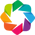

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh', 'matplotlib', width='100')


In [146]:
path = '../data/processed/'
data = load_from(path + 'data.pkl')
cv = load_from(path + 'cv.pkl')
holdout = load_from(path + 'holdout.pkl')
record = pd.read_pickle('../models/records/model_history.pkl')
top_5 = record[record['Desc'].str.contains('CV')].sort_values(by='Test Score', ascending=False)
display(top_5.head(8))

Model                                               Desc  \
290        Random Forest  Thresh: 0.7387755102040815. CV - k: 12, f: 20:...   
300        Random Forest  Thresh: 0.7755102040816326. CV - k: 6, f: 40: ...   
285        Random Forest  Thresh: 0.757142857142857. CV - k: 6, f: 20: O...   
282  Logistic Regression  Thresh: 1.0. CV - k: 5, f: 40, l2, others defa...   
298             Relu MLP  Thresh: 0.8387755102040815. CV - k: 18, f: 20:...   
295        Random Forest  Thresh: 0.7551020408163265. CV - k: 18, f: 20:...   
288             Relu MLP  Thresh: 0.8795918367346939. CV - k: 6, f: 20: ...   
293             Relu MLP  Thresh: 0.8. CV - k: 12, f: 20: CV - k: 6, f: ...   

    Features     Target Train/Test Observations         Train Balance  \
290       12  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
300        6  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
285        6  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
282        5  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
298       18  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
295       18  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
288        6  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
293       12  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   

     Train Score  Test Score  Train F1   Test F1                     Train CM  \
290     0.995845    0.259428  0.998073  0.407300    [[871168, 0], [17, 3967]]   
300     0.995867    0.258744  0.998053  0.406546    [[871167, 1], [13, 3971]]   
285     0.996099    0.258744  0.998046  0.406546    [[871168, 0], [16, 3968]]   
282     0.062750    0.258560  0.104118  0.406328     [[871168, 0], [3984, 0]]   
298     0.335205    0.258392  0.502415  0.406008  [[871168, 0], [2697, 1287]]   
295     0.994396    0.258382  0.997452  0.405991    [[871167, 1], [25, 3959]]   
288     0.335714    0.258216  0.502616  0.405884  [[871168, 0], [2692, 1292]]   
293     0.334901    0.257873  0.502097  0.405359  [[871168, 0], [2693, 1291]]   

                      Test CM  \
290  [[118728, 0], [500, 83]]   
300  [[118728, 0], [499, 84]]   
285  [[118728, 0], [499, 84]]   
282  [[118727, 1], [498, 85]]   
298  [[118728, 0], [500, 83]]   
295  [[118728, 0], [500, 83]]   
288  [[118728, 0], [499, 84]]   
293  [[118728, 0], [500, 83]]   

                                       Hyperparameters  
290  {'bootstrap': True, 'class_weight': None, 'cri...  
300  {'bootstrap': True, 'class_weight': None, 'cri...  
285  {'bootstrap': True, 'class_weight': None, 'cri...  
282  {'C': 1.0, 'class_weight': None, 'dual': False...  
298  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
295  {'bootstrap': True, 'class_weight': None, 'cri...  
288  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
293  {'activation': 'relu', 'alpha': 0.0001, 'batch...

In [34]:
record.to_sql('record', engine, if_exists='replace')

ProgrammingError: (psycopg2.ProgrammingError) can't adapt type 'dict'
[SQL: INSERT INTO record (index, "Model", "Desc", "Features", "Target", "Train/Test Observations", "Train Balance", "Train Score", "Test Score", "Train F1", "Test F1", "Train CM", "Test CM", "Hyperparameters") VALUES (%(index)s, %(Model)s, %(Desc)s, %(Features)s, %(Target)s, %(Train/Test Observations)s, %(Train Balance)s, %(Train Score)s, %(Test Score)s, %(Train F1)s, %(Test F1)s, %(Train CM)s, %(Test CM)s, %(Hyperparameters)s)]
[parameters: ({'index': 0, 'Model': 'Logistic Regression', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': 0.0, 'Test Score': 0.0, 'Train F1': 0.0, 'Test F1': 0.0, 'Train CM': array([[98213,     0],
       [  615,     0]]), 'Test CM': array([[98375,     0],
       [  453,     0]]), 'Hyperparameters': {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}}, {'index': 1, 'Model': 'KNN', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': -0.06253908692933083, 'Test Score': -0.5948378332484292, 'Train F1': 0.009600000000000001, 'Test F1': 0.011952191235059759, 'Train CM': array([[98206,     7],
       [  612,     3]]), 'Test CM': array([[98329,    46],
       [  450,     3]]), 'Hyperparameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}}, {'index': 2, 'Model': 'Naive Bayes', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': 0.0, 'Test Score': 0.0, 'Train F1': 0.0, 'Test F1': 0.0, 'Train CM': array([[98213,     0],
       [  615,     0]]), 'Test CM': array([[98375,     0],
       [  453,     0]]), 'Hyperparameters': {'priors': None, 'var_smoothing': 1e-09}}, {'index': 3, 'Model': 'Linear SVM', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': 0.0, 'Test Score': 0.0, 'Train F1': 0.0, 'Test F1': 0.0, 'Train CM': array([[98213,     0],
       [  615,     0]]), 'Test CM': array([[98375,     0],
       [  453,     0]]), 'Hyperparameters': {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}}, {'index': 4, 'Model': 'Radial SVM', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': 0.0, 'Test Score': 0.0, 'Train F1': 0.0, 'Test F1': 0.0, 'Train CM': array([[98213,     0],
       [  615,     0]]), 'Test CM': array([[98375,     0],
       [  453,     0]]), 'Hyperparameters': {'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}}, {'index': 5, 'Model': 'Random Forest', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': 0.0016260162601626016, 'Test Score': -0.13075224995754797, 'Train F1': 0.0032467532467532465, 'Test F1': 0.0, 'Train CM': array([[98213,     0],
       [  614,     1]]), 'Test CM': array([[98365,    10],
       [  453,     0]]), 'Hyperparameters': {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrea ... (80 characters truncated) ... : 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}}, {'index': 6, 'Model': 'Gradient Boosting', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': 0.0, 'Test Score': 0.0, 'Train F1': 0.0, 'Test F1': 0.0, 'Train CM': array([[98213,     0],
       [  615,     0]]), 'Test CM': array([[98375,     0],
       [  453,     0]]), 'Hyperparameters': {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'm ... (169 characters truncated) ... hange': None, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}}, {'index': 7, 'Model': 'Adaptive Boosting', 'Desc': 'MVP suite', 'Features': 2, 'Target': 'cancelled', 'Train/Test Observations': (98828, 98828), 'Train Balance': {0: 98213, 1: 615}, 'Train Score': 0.0, 'Test Score': 0.0, 'Train F1': 0.0, 'Test F1': 0.0, 'Train CM': array([[98213,     0],
       [  615,     0]]), 'Test CM': array([[98375,     0],
       [  453,     0]]), 'Hyperparameters': {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}}  ... displaying 10 of 397 total bound parameter sets ...  {'index': 395, 'Model': 'Random Forest', 'Desc': 'Thresh: 0.512. CVT - k12, f20: Random Forest', 'Features': 12, 'Target': 'cancelled', 'Train/Test Observations': (602061, 119311), 'Train Balance': {0: 599624, 1: 2437}, 'Train Score': 0.9918866285184663, 'Test Score': 0.24368212064942557, 'Train F1': 0.9992816070642864, 'Test F1': 0.40183985201247274, 'Train CM': array([[599620,      4],
       [     1,   2436]]), 'Test CM': array([[118726,      2],
       [   502,     81]]), 'Hyperparameters': {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_ ... (84 characters truncated) ... t': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': 3, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}}, {'index': 396, 'Model': 'Random Forest', 'Desc': 'Thresh: 0.512. CVT - k12, f20: Random Forest', 'Features': 12, 'Target': 'cancelled', 'Train/Test Observations': (629720, 120975), 'Train Balance': {0: 627157, 1: 2563}, 'Train Score': 0.9725682043278611, 'Test Score': -0.14642006445285136, 'Train F1': 0.9949198905822586, 'Test F1': 0.14332247557003258, 'Train CM': array([[627148,      9],
       [    17,   2546]]), 'Test CM': array([[120405,     21],
       [   505,     44]]), 'Hyperparameters': {'base_estimator__bootstrap': True, 'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None ... (838 characters truncated) ...           n_estimators=200, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False), 'cv': 'warn', 'method': 'sigmoid'}})]
(Background on this error at: http://sqlalche.me/e/f405)

In [36]:
record.head()

Model       Desc Features     Target Train/Test Observations  \
0  Logistic Regression  MVP suite        2  cancelled          (98828, 98828)   
1                  KNN  MVP suite        2  cancelled          (98828, 98828)   
2          Naive Bayes  MVP suite        2  cancelled          (98828, 98828)   
3           Linear SVM  MVP suite        2  cancelled          (98828, 98828)   
4           Radial SVM  MVP suite        2  cancelled          (98828, 98828)   

        Train Balance  Train Score  Test Score  Train F1   Test F1  \
0  {0: 98213, 1: 615}     0.000000    0.000000    0.0000  0.000000   
1  {0: 98213, 1: 615}    -0.062539   -0.594838    0.0096  0.011952   
2  {0: 98213, 1: 615}     0.000000    0.000000    0.0000  0.000000   
3  {0: 98213, 1: 615}     0.000000    0.000000    0.0000  0.000000   
4  {0: 98213, 1: 615}     0.000000    0.000000    0.0000  0.000000   

                 Train CM                  Test CM  \
0  [[98213, 0], [615, 0]]   [[98375, 0], [453, 0]]   
1  [[98206, 7], [612, 3]]  [[98329, 46], [450, 3]]   
2  [[98213, 0], [615, 0]]   [[98375, 0], [453, 0]]   
3  [[98213, 0], [615, 0]]   [[98375, 0], [453, 0]]   
4  [[98213, 0], [615, 0]]   [[98375, 0], [453, 0]]   

                                     Hyperparameters  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  
1  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
2           {'priors': None, 'var_smoothing': 1e-09}  
3  {'C': 1.0, 'class_weight': None, 'dual': True,...  
4  {'C': 1.0, 'cache_size': 200, 'class_weight': ...

In [66]:
def transform_record(df):
    drop_cols = ['Train/Test Observations', 'Train Balance', 'Train CM',
                 'Test CM', 'Hyperparameters']
    tf = df.drop(drop_cols, axis=1)
    
    for split in ['Train', 'Test']:
        tf[f'{split}_TN'] = df[f'{split} CM'].apply(lambda x: x[0][0])
        tf[f'{split}_FN'] = df[f'{split} CM'].apply(lambda x: x[0][1])
        tf[f'{split}_FP'] = df[f'{split} CM'].apply(lambda x: x[1][0])
        tf[f'{split}_TP'] = df[f'{split} CM'].apply(lambda x: x[1][1])
        tf[f'{split}_Len'] = df['Train/Test Observations'].apply(
            lambda x: x[split == 'Test'])
    return tf
trans_record = transform_record(record)
trans_record.head()

Model       Desc Features     Target  Train Score  \
0  Logistic Regression  MVP suite        2  cancelled     0.000000   
1                  KNN  MVP suite        2  cancelled    -0.062539   
2          Naive Bayes  MVP suite        2  cancelled     0.000000   
3           Linear SVM  MVP suite        2  cancelled     0.000000   
4           Radial SVM  MVP suite        2  cancelled     0.000000   

   Test Score  Train F1   Test F1  Train_TN  Train_FN  Train_FP  Train_TP  \
0    0.000000    0.0000  0.000000     98213         0       615         0   
1   -0.594838    0.0096  0.011952     98206         7       612         3   
2    0.000000    0.0000  0.000000     98213         0       615         0   
3    0.000000    0.0000  0.000000     98213         0       615         0   
4    0.000000    0.0000  0.000000     98213         0       615         0   

   Train_Len  Test_TN  Test_FN  Test_FP  Test_TP  Test_Len  
0      98828    98375        0      453        0     98828  
1      98828    98329       46      450        3     98828  
2      98828    98375        0      453        0     98828  
3      98828    98375        0      453        0     98828  
4      98828    98375        0      453        0     98828

In [67]:
trans_record.to_sql('record', engine, if_exists='replace')

In [87]:
data.head()

cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2007-01-01          0    320.0      2553   0.007407   0.010676   0.010601   
2007-01-01          0    161.0      1050   0.007407   0.010676   0.010601   
2007-01-01          0    219.0      1449   0.007407   0.010676   0.010601   
2007-01-01          0    193.0      1399   0.007407   0.010676   0.010601   
2007-01-01          0    173.0      1216   0.007407   0.010676   0.010601   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.125                     0.000000  ...   
2007-01-01                        0.000                     0.023438  ...   

            1400-1459  1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  \
date                                                                           
2007-01-01          0          0          0          0          0          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          1          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          0          0   

            2000-2059  2100-2159  2200-2259  2300-2359  
date                                                    
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  

[5 rows x 92 columns]

In [110]:
grouped = data.groupby('date').mean()
display(grouped.columns, grouped.head())

Index(['cancelled', 'distance', 'cr_1d_ago', 'cr_1w_ago', 'cr_4w_ago',
       'cr_52w_ago', 'reporting_airline_cr_1d_ago',
       'reporting_airline_cr_1w_ago', 'reporting_airline_cr_4w_ago',
       'reporting_airline_cr_52w_ago', 'dest_cr_1d_ago', 'dest_cr_1w_ago',
       'dest_cr_4w_ago', 'dest_cr_52w_ago', 'destcitymarketid_cr_1d_ago',
       'destcitymarketid_cr_1w_ago', 'destcitymarketid_cr_4w_ago',
       'destcitymarketid_cr_52w_ago', 'deptimeblk_cr_1d_ago',
       'deptimeblk_cr_1w_ago', 'deptimeblk_cr_4w_ago', 'deptimeblk_cr_52w_ago',
       'arrtimeblk_cr_1d_ago', 'arrtimeblk_cr_1w_ago', 'arrtimeblk_cr_4w_ago',
       'arrtimeblk_cr_52w_ago', 'tail_number_cr_1d_ago',
       'tail_number_cr_1w_ago', 'tail_number_cr_4w_ago', '7_day_CR_avg',
       '7_day_CR_avg_by_reporting_airline', '7_day_CR_avg_by_dest',
       '7_day_CR_avg_by_destcitymarketid', '7_day_CR_avg_by_deptimeblk',
       '7_day_CR_avg_by_arrtimeblk', '30_day_CR_avg',
       '30_day_CR_avg_by_reporting_airline', '

cancelled     distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                  
2007-01-01   0.014760  1147.033210   0.007407   0.010676   0.010601   
2007-01-02   0.011152  1168.546468   0.013841   0.010135   0.010714   
2007-01-03   0.003663  1170.300366   0.013652   0.006734   0.010638   
2007-01-04   0.022305  1135.881041   0.003460   0.026936   0.017544   
2007-01-05   0.033582  1142.902985   0.020906   0.016892   0.007067   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2007-01-01    0.003390                     0.006780   
2007-01-02    0.017123                     0.014286   
2007-01-03    0.010676                     0.014535   
2007-01-04    0.021277                     0.003658   
2007-01-05    0.024911                     0.021074   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  \
date                                                                   
2007-01-01                     0.010345                     0.010811   
2007-01-02                     0.009174                     0.010481   
2007-01-03                     0.007093                     0.010705   
2007-01-04                     0.027529                     0.017717   
2007-01-05                     0.017516                     0.007288   

            reporting_airline_cr_52w_ago  ...  1400-1459  1500-1559  \
date                                      ...                         
2007-01-01                      0.003163  ...   0.062731   0.066421   
2007-01-02                      0.017461  ...   0.059480   0.059480   
2007-01-03                      0.010646  ...   0.047619   0.069597   
2007-01-04                      0.021778  ...   0.059480   0.066914   
2007-01-05                      0.025486  ...   0.063433   0.070896   

            1600-1659  1700-1759  1800-1859  1900-1959  2000-2059  2100-2159  \
date                                                                           
2007-01-01   0.040590   0.051661   0.047970   0.051661   0.033210   0.033210   
2007-01-02   0.044610   0.059480   0.048327   0.055762   0.033457   0.029740   
2007-01-03   0.040293   0.054945   0.051282   0.054945   0.029304   0.036630   
2007-01-04   0.037175   0.055762   0.052045   0.052045   0.033457   0.033457   
2007-01-05   0.033582   0.052239   0.052239   0.055970   0.033582   0.033582   

            2200-2259  2300-2359  
date                              
2007-01-01   0.022140   0.029520  
2007-01-02   0.018587   0.029740  
2007-01-03   0.021978   0.029304  
2007-01-04   0.022305   0.026022  
2007-01-05   0.022388   0.033582  

[5 rows x 91 columns]

In [108]:
cols = ['cr_1d_ago', 'cr_1w_ago', 'cr_4w_ago',
       'cr_52w_ago', 'reporting_airline_cr_1d_ago',
       'reporting_airline_cr_1w_ago', 'reporting_airline_cr_4w_ago',
       'reporting_airline_cr_52w_ago', 'dest_cr_1d_ago', 'dest_cr_1w_ago',
       'dest_cr_4w_ago', 'dest_cr_52w_ago', 'destcitymarketid_cr_1d_ago',
       'destcitymarketid_cr_1w_ago', 'destcitymarketid_cr_4w_ago',
       'destcitymarketid_cr_52w_ago', 'deptimeblk_cr_1d_ago',
       'deptimeblk_cr_1w_ago', 'deptimeblk_cr_4w_ago', 'deptimeblk_cr_52w_ago',
       'arrtimeblk_cr_1d_ago', 'arrtimeblk_cr_1w_ago', 'arrtimeblk_cr_4w_ago',
       'arrtimeblk_cr_52w_ago', 'tail_number_cr_1d_ago',
       'tail_number_cr_1w_ago', 'tail_number_cr_4w_ago', '7_day_CR_avg',
       '7_day_CR_avg_by_reporting_airline', '7_day_CR_avg_by_dest',
       '7_day_CR_avg_by_destcitymarketid', '7_day_CR_avg_by_deptimeblk',
       '7_day_CR_avg_by_arrtimeblk', '30_day_CR_avg',
       '30_day_CR_avg_by_reporting_airline', '30_day_CR_avg_by_dest',
       '30_day_CR_avg_by_destcitymarketid', '30_day_CR_avg_by_deptimeblk',
       '30_day_CR_avg_by_arrtimeblk', '365_day_CR_avg',
       '365_day_CR_avg_by_reporting_airline', '365_day_CR_avg_by_dest',
       '365_day_CR_avg_by_destcitymarketid', '365_day_CR_avg_by_deptimeblk',
       '365_day_CR_avg_by_arrtimeblk']

In [118]:
grouped['2018'][cols].hvplot(size=22)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [112]:
grouped['2018']

cancelled     distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                  
2018-01-01   0.000000  1265.609907   0.009119   0.020772   0.002817   
2018-01-02   0.005935  1225.646884   0.000000   0.000000   0.002950   
2018-01-03   0.021672  1232.365325   0.005249   0.000000   0.000000   
2018-01-04   0.052147  1237.570552   0.021798   0.007712   0.000000   
2018-01-05   0.002976  1240.675595   0.051351   0.005128   0.025210   
2018-01-06   0.007220  1266.346570   0.005362   0.002809   0.013937   
2018-01-07   0.009615  1236.923077   0.006431   0.009119   0.002941   
2018-01-08   0.021944  1198.771160   0.011080   0.000000   0.000000   
2018-01-09   0.006579  1154.986842   0.019718   0.005249   0.002941   
2018-01-10   0.009772  1202.885993   0.005848   0.021798   0.002907   
2018-01-11   0.012618  1227.577287   0.008721   0.051351   0.002762   
2018-01-12   0.012579  1228.540881   0.011268   0.005362   0.002618   
2018-01-13   0.003704  1248.148148   0.011173   0.006431   0.006452   
2018-01-14   0.000000  1227.092150   0.003344   0.011080   0.011080   
2018-01-15   0.003106  1198.704969   0.000000   0.019718   0.010471   
2018-01-16   0.023026  1160.779605   0.002825   0.005848   0.000000   
2018-01-17   0.013158  1189.549342   0.020408   0.008721   0.000000   
2018-01-18   0.003135  1205.326019   0.014451   0.011268   0.000000   
2018-01-19   0.000000  1215.025078   0.002817   0.011173   0.000000   
2018-01-20   0.003802  1256.969582   0.000000   0.003344   0.000000   
2018-01-21   0.009934  1218.897351   0.003378   0.000000   0.003077   
2018-01-22   0.015823  1195.844937   0.008982   0.002825   0.020772   
2018-01-23   0.009772  1148.361564   0.016901   0.020408   0.000000   
2018-01-24   0.006329  1191.955696   0.008721   0.014451   0.000000   
2018-01-25   0.003049  1202.652439   0.005764   0.002817   0.007712   
2018-01-26   0.000000  1220.869427   0.002809   0.000000   0.005128   
2018-01-27   0.000000  1247.574144   0.000000   0.003378   0.002809   
2018-01-28   0.006667  1214.450000   0.003367   0.008982   0.009119   
2018-01-29   0.006270  1205.608150   0.005988   0.016901   0.000000   
2018-01-30   0.000000  1179.722408   0.005618   0.008721   0.005249   
...               ...          ...        ...        ...        ...   
2018-12-02   0.000000  1321.409836   0.003378   0.015504   0.000000   
2018-12-03   0.000000  1300.300310   0.000000   0.010363   0.000000   
2018-12-04   0.006494  1290.243506   0.000000   0.000000   0.005882   
2018-12-05   0.000000  1311.873786   0.006006   0.002915   0.000000   
2018-12-06   0.000000  1318.093168   0.002985   0.005602   0.000000   
2018-12-07   0.000000  1313.306748   0.000000   0.000000   0.002695   
2018-12-08   0.003731  1295.611940   0.000000   0.003378   0.003300   
2018-12-09   0.006849  1329.993151   0.003460   0.000000   0.000000   
2018-12-10   0.000000  1294.626168   0.006135   0.000000   0.000000   
2018-12-11   0.003226  1295.148387   0.000000   0.006006   0.002809   
2018-12-12   0.000000  1297.751613   0.003021   0.002985   0.002778   
2018-12-13   0.000000  1306.666667   0.000000   0.000000   0.007772   
2018-12-14   0.000000  1310.079114   0.000000   0.000000   0.007833   
2018-12-15   0.003690  1300.498155   0.002825   0.003460   0.003049   
2018-12-16   0.000000  1339.506623   0.003436   0.006135   0.000000   
2018-12-17   0.002976  1296.095238   0.000000   0.000000   0.002710   
2018-12-18   0.000000  1290.408228   0.002833   0.003021   0.070081   
2018-12-19   0.000000  1313.584848   0.000000   0.000000   0.002618   
2018-12-20   0.002924  1323.874269   0.000000   0.000000   0.003636   
2018-12-21   0.002899  1328.692754   0.002653   0.002825   0.006329   
2018-12-22   0.002985  1363.370149   0.002681   0.003436   0.002732   
2018-12-23   0.000000  1336.906061   0.002778   0.000000   0.015504   
2018-12-24   0.000000  1346.813115   0.000000   0.002833   0.010363   
2018-12-25   0.009934  1334.248344  

In [126]:
df[df['Test Score'] > 1 & df['Desc'].str.contains('CV')].hvplot.violin(y='Test Score', by='Model')

:Violin   [Model]   (Test Score)

In [128]:
data = df[df['Test Score'] > 1 & df['Desc'].str.contains('CV')]
data = df.groupby(by='Model').max()
sns.barplot(x='Test Score', y='Model', data=data)

ValueError: Could not interpret input 'Model'

/anaconda3/envs/project3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


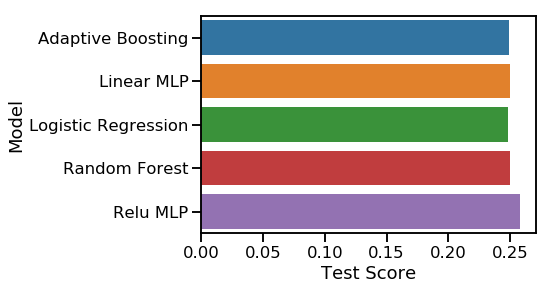

In [144]:
f = (df['Desc'].str.contains('CVT')) * (df['Test Score'] > -1)
data = df[f][['Model','Test Score']].groupby(by='Model').max().reset_index()
sns.barplot(x='Test Score', y='Model', data=data)

In [143]:
data

Model  Test Score
0    Adaptive Boosting    0.307387
1    Gradient Boosting    0.152196
2                  KNN    0.308975
3           Linear MLP    0.308975
4           Linear SVM    0.308975
5  Logistic Regression    0.287041
6          Naive Bayes    0.000000
7           Radial SVM    0.252581
8        Random Forest    0.307387
9             Relu MLP    0.302682

In [174]:
data.head()

cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2007-01-01          0    320.0      2553   0.007407   0.010676   0.010601   
2007-01-01          0    161.0      1050   0.007407   0.010676   0.010601   
2007-01-01          0    219.0      1449   0.007407   0.010676   0.010601   
2007-01-01          0    193.0      1399   0.007407   0.010676   0.010601   
2007-01-01          0    173.0      1216   0.007407   0.010676   0.010601   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.125                     0.000000  ...   
2007-01-01                        0.000                     0.023438  ...   

            1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  2000-2059  \
date                                                                           
2007-01-01          0          0          0          0          0          0   
2007-01-01          1          0          0          0          0          0   
2007-01-01          0          0          0          1          0          0   
2007-01-01          1          0          0          0          0          0   
2007-01-01          0          0          0          0          0          0   

            2100-2159  2200-2259  2300-2359  month  
date                                                
2007-01-01          0          0          0      1  
2007-01-01          0          0          0      1  
2007-01-01          0          0          0      1  
2007-01-01          0          0          0      1  
2007-01-01          0          0          0      1  

[5 rows x 93 columns]

In [170]:
data.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='date', length=1202639)

In [183]:
cols = ['cr_4w_ago', 
        'reporting_airline_cr_4w_ago', 
        'dest_cr_4w_ago', 
        'deptimeblk_cr_4w_ago', 
        'arrtimeblk_cr_4w_ago',
        'tail_number_cr_4w_ago',
        'month']
data['month'] = data.index.month
grouped = data['2017'][cols].groupby(by='month').mean()
cols = ['Overall Cancellation Rate',
        'Cancellation Rate by Airline', 
        'Cancellation Rate by Destination', 
        'Cancellation Rate by Departure Time', 
        'Cancellation Rate by Arrival Time',
        'Cancellation Rate by Aircraft',
]
grouped.columns = cols
grouped.hvplot()

:NdOverlay   [Variable]
   :Curve   [month]   (value)

In [153]:
data.columns

Index(['cancelled', 'est_time', 'distance', 'cr_1d_ago', 'cr_1w_ago',
       'cr_4w_ago', 'cr_52w_ago', 'reporting_airline_cr_1d_ago',
       'reporting_airline_cr_1w_ago', 'reporting_airline_cr_4w_ago',
       'reporting_airline_cr_52w_ago', 'dest_cr_1d_ago', 'dest_cr_1w_ago',
       'dest_cr_4w_ago', 'dest_cr_52w_ago', 'destcitymarketid_cr_1d_ago',
       'destcitymarketid_cr_1w_ago', 'destcitymarketid_cr_4w_ago',
       'destcitymarketid_cr_52w_ago', 'deptimeblk_cr_1d_ago',
       'deptimeblk_cr_1w_ago', 'deptimeblk_cr_4w_ago', 'deptimeblk_cr_52w_ago',
       'arrtimeblk_cr_1d_ago', 'arrtimeblk_cr_1w_ago', 'arrtimeblk_cr_4w_ago',
       'arrtimeblk_cr_52w_ago', 'tail_number_cr_1d_ago',
       'tail_number_cr_1w_ago', 'tail_number_cr_4w_ago', '7_day_CR_avg',
       '7_day_CR_avg_by_reporting_airline', '7_day_CR_avg_by_dest',
       '7_day_CR_avg_by_destcitymarketid', '7_day_CR_avg_by_deptimeblk',
       '7_day_CR_avg_by_arrtimeblk', '30_day_CR_avg',
       '30_day_CR_avg_by_reporting

In [271]:
dm = """
SELECT
    CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
        AS flight,
    CAST(flightdate AS DATE) AS date,
    cancelled,
    crselapsedtime AS est_time,
    distance,
    reporting_airline,
    tail_number,
    dest,
    destcitymarketid,
    deptimeblk,
    arrtimeblk
FROM flights
WHERE flightdate between '2015-01-01' AND '2018-12-31' AND
    origin = 'SEA'
ORDER BY date
;"""
df = pd.read_sql(dm, engine, index_col='flight')
df = df.set_index(pd.DatetimeIndex(df.date)).drop('distance', axis=1)
df['month'] = df.index.month
df.head()

date  cancelled est_time reporting_airline tail_number dest  \
date                                                                            
2015-01-01  2015-01-01          0    122.0                UA      N849UA  SFO   
2015-01-01  2015-01-01          0    155.0                VX      N635VA  LAX   
2015-01-01  2015-01-01          0    150.0                VX      N525VA  LAX   
2015-01-01  2015-01-01          0    150.0                VX      N847VA  LAX   
2015-01-01  2015-01-01          0    125.0                VX      N642VA  SFO   

           destcitymarketid deptimeblk arrtimeblk  month  
date                                                      
2015-01-01            32457  1100-1159  1300-1359      1  
2015-01-01            32575  2000-2059  2300-2359      1  
2015-01-01            32575  1500-1559  1700-1759      1  
2015-01-01            32575  1000-1059  1300-1359      1  
2015-01-01            32457  1900-1959  2100-2159      1

In [272]:
grouped = df.groupby(by='month').mean()
grouped.columns = ['Cancellation Rate']
grouped['Cancellation Rate by Tail Number'] = df[
    df['tail_number'].str[-2:] == 'AS'].groupby(
    by=['month', 'tail_number']).mean().reset_index()['cancelled']
grouped['Cancellation Rate by Airline'] = df[
    df['reporting_airline'] == 'AS'].groupby(
    by=['month', 'reporting_airline']).mean().reset_index()['cancelled']
grouped['Cancellation Rate by Destination'] = df[
    df['dest'] == 'LAX'].groupby(
    by=['month', 'dest']).mean().reset_index()['cancelled']
grouped['Cancellation Rate by Departure Time'] = df[
    df['deptimeblk'] == '2200-2259'].groupby(
    by=['month', 'deptimeblk']).mean().reset_index()['cancelled']
grouped['Cancellation Rate by Arrival Time'] = df[
    df['arrtimeblk'] == '0600-0659'].groupby(
    by=['month', 'arrtimeblk']).mean().reset_index()['cancelled']
grouped.head()

Cancellation Rate  Cancellation Rate by Tail Number  \
month                                                        
1               0.008532                          0.019481   
2               0.007384                          0.013333   
3               0.004149                          0.000000   
4               0.003123                          0.000000   
5               0.002620                          0.000000   

       Cancellation Rate by Airline  Cancellation Rate by Destination  \
month                                                                   
1                          0.006575                          0.005573   
2                          0.002707                          0.003734   
3                          0.001708                          0.004850   
4                          0.001899                          0.008516   
5                          0.002070                          0.004575   

       Cancellation Rate by Departure Time  Cancellation Rate by Arrival Time  
month                                                                          
1                                 0.019139                           0.006378  
2                                 0.009909                           0.010030  
3                                 0.003968                           0.006329  
4                                 0.001363                           0.002349  
5                                 0.007831                           0.009340

In [273]:
gplot = grouped.hvplot(
    xlabel='Month',
    ylabel='Cancellation Rate',
    width=1000,
    height=500,
    
)
hvplot.save(gplot, '../reports/figures/test.png')
gplot

:NdOverlay   [Variable]
   :Curve   [month]   (value)

In [243]:
df[df['tail_number'].str[-2:] == 'AS'].dropna().groupby(by=['month']).mean()

cancelled
month           
1       0.010236
2       0.021774
3       0.002605
4       0.001650
5       0.004733
6       0.002043
7       0.001546
8       0.004765
9       0.006094
10      0.001308
11      0.005850
12      0.003001

In [232]:
df.groupby(by=['month', 'arrtimeblk']).mean().sort_values(by='cancelled', ascending=False)

cancelled
month arrtimeblk           
2     1100-1159    0.048327
      0001-0559    0.030471
      2300-2359    0.028143
9     0600-0659    0.026596
      0700-0759    0.025000
2     1000-1059    0.024814
8     0600-0659    0.024621
2     2000-2059    0.023936
      0800-0859    0.022917
1     1100-1159    0.022152
2     0900-0959    0.021912
1     2300-2359    0.021002
      1000-1059    0.020595
8     0001-0559    0.020305
      0900-0959    0.020290
2     0700-0759    0.018433
4     0600-0659    0.018182
11    1100-1159    0.017817
6     0700-0759    0.016949
2     1200-1259    0.016779
      1900-1959    0.015909
5     0800-0859    0.015845
1     0800-0859    0.015504
8     1100-1159    0.014925
1     0900-0959    0.014898
5     0900-0959    0.014888
10    1000-1059    0.014658
2     2100-2159    0.014414
      1600-1659    0.014365
10    0700-0759    0.014286
...                     ...
7     0001-0559    0.001276
6     1400-1459    0.001140
7     2100-2159    0.001093
      1400-1459    0.001064
8     2300-2359    0.000954
7     2200-2259    0.000000
8     1900-1959    0.000000
1     1800-1859    0.000000
6     1700-1759    0.000000
9     1900-1959    0.000000
      2100-2159    0.000000
12    1700-1759    0.000000
10    0800-0859    0.000000
9     1000-1059    0.000000
4     2200-2259    0.000000
8     2100-2159    0.000000
      1500-1559    0.000000
6     1100-1159    0.000000
5     1500-1559    0.000000
      1700-1759    0.000000
12    0600-0659    0.000000
7     0900-0959    0.000000
      1000-1059    0.000000
5     2000-2059    0.000000
11    0600-0659    0.000000
5     2200-2259    0.000000
7     2300-2359    0.000000
      1700-1759    0.000000
      1800-1859    0.000000
4     2000-2059    0.000000

[228 rows x 1 columns]

In [266]:
grouped.to_csv('../reports/grouped.csv')